# Sea ice proxy comparison

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import pandas as pd
import xarray as xr

from scipy import signal
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/instrumental_assimilation_experiments/')
import reanalysis_recons_utils as rrutils

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/')
import commonera_utils as ce_utils 

Loading information from datasets.yml
Loading information from grid_def.yml
Loading information from datasets.yml
Loading information from grid_def.yml


In [3]:
def load_ccsm4_lm_regridded():
    ccsm4_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/'
    ccsm4_file = 'ccsm4_sic_sit_tas_20CRv2_850_1850_full.npz'

    ccsm4_lm = np.load(ccsm4_dir+ccsm4_file)

    ccsm4_truth_sic = ccsm4_lm['sic_ccsm4']
    ccsm4_truth_sit = ccsm4_lm['sit_ccsm4']
    ccsm4_truth_tas = ccsm4_lm['tas_ccsm4']
    ccsm4_truth_lat = ccsm4_lm['lat_ccsm4']
    ccsm4_truth_lon = ccsm4_lm['lon_ccsm4']
    
    return ccsm4_truth_tas, ccsm4_truth_sic, ccsm4_truth_sit, ccsm4_truth_lat, ccsm4_truth_lon

In [4]:
def load_recon_allit(output_dir,filename,niter,prox_loc=True, tas=False):

    for it in range(niter):
        output_file = filename[:-5]+str(it)+'.pkl'

        if prox_loc is True: 
            if tas is True: 
                [sic_lalo, tas_lalo, sic_ens_var,nobs, sia_ens, sie_ens, recon_years, 
                 Ye_assim, Ye_assim_coords, Xb_inflate, proxy_assim_loc, 
                 cutoff_count_pos,cutoff_count_neg, gmtas_ens, 
                 nhmtas_ens, amtas_ens] = load_recon(output_dir+output_file, tas=True)
            else: 
                [sic_lalo, tas_lalo, sic_ens_var, 
                 nobs, sia_ens, sie_ens, recon_years, 
                 Ye_assim, Ye_assim_coords, Xb_inflate, proxy_assim_loc] = load_recon(output_dir+output_file)          
        else: 
            if tas is True: 
                [sic_lalo, tas_lalo, sic_ens_var,nobs, sia_ens, sie_ens, recon_years, 
                 Ye_assim, Ye_assim_coords, Xb_inflate, proxy_assim_loc, 
                 cutoff_count_pos,cutoff_count_neg, gmtas_ens, 
                 nhmtas_ens, amtas_ens] = load_recon(output_dir+output_file, prox_loc=False, tas=True)
            else: 
                [sic_lalo, tas_lalo, sic_ens_var, 
                 nobs, sia_ens, sie_ens, recon_years, 
                 Ye_assim, Ye_assim_coords, Xb_inflate] = load_recon(output_dir+output_file, prox_loc=False)

        if it is 0: 
            sic_lalo_allit = np.zeros((sic_lalo.shape[0],sic_lalo.shape[1],sic_lalo.shape[2],niter))
            tas_lalo_allit = np.zeros((tas_lalo.shape[0],tas_lalo.shape[1],tas_lalo.shape[2],niter))
            sic_ens_var_allit = np.zeros(niter)
            nobs_allit = np.zeros((nobs.shape[0],niter))
            sia_ens_allit = np.zeros((sia_ens.shape[0],sia_ens.shape[1],niter))
            sie_ens_allit = np.zeros((sie_ens.shape[0],sie_ens.shape[1],niter))
            Ye_assim_allit = np.zeros((Ye_assim.shape[0],Ye_assim.shape[1],niter))
            Ye_assim_coords_allit = np.zeros((Ye_assim_coords.shape[0],Ye_assim_coords.shape[1],niter))
            Xb_inflate_allit = np.zeros((Xb_inflate.shape[0],Xb_inflate.shape[1],niter))
            if prox_loc is True: 
                proxy_assim_loc_allit = {}
                
                if tas is True: 
                    cutoff_count_pos_allit = np.zeros(niter)
                    cutoff_count_neg_allit = np.zeros(niter)
                    gmtas_ens_allit = np.zeros((gmtas_ens.shape[0],gmtas_ens.shape[1],niter))
                    nhmtas_ens_allit = np.zeros((nhmtas_ens.shape[0],nhmtas_ens.shape[1],niter))
                    amtas_ens_allit = np.zeros((amtas_ens.shape[0],amtas_ens.shape[1],niter))
            else: 
                if tas is True: 
                    cutoff_count_pos_allit = np.zeros(niter)
                    cutoff_count_neg_allit = np.zeros(niter)
                    gmtas_ens_allit = np.zeros((gmtas_ens.shape[0],gmtas_ens.shape[1],niter))
                    nhmtas_ens_allit = np.zeros((nhmtas_ens.shape[0],nhmtas_ens.shape[1],niter))
                    amtas_ens_allit = np.zeros((amtas_ens.shape[0],amtas_ens.shape[1],niter))

        sic_lalo_allit[:,:,:,it] = sic_lalo
        tas_lalo_allit[:,:,:,it] = tas_lalo
        sic_ens_var_allit[it] = niter
        nobs_allit[:,it] = nobs
        sia_ens_allit[:,:,it] = sia_ens
        sie_ens_allit[:,:,it] = sie_ens
        Ye_assim_allit[:,:,it] = Ye_assim
        Ye_assim_coords_allit[:,:,it] = Ye_assim_coords
        Xb_inflate_allit[:,:,it] = Xb_inflate
        if prox_loc is True: 
            proxy_assim_loc_allit['iter '+str(it)] = proxy_assim_loc
            
            if tas is True: 
                cutoff_count_pos_allit[it] = cutoff_count_pos
                cutoff_count_neg_allit[it] = cutoff_count_neg
                gmtas_ens_allit[:,:,it] = gmtas_ens
                nhmtas_ens_allit[:,:,it] = nhmtas_ens
                amtas_ens_allit[:,:,it] = amtas_ens
        else: 
            if tas is True: 
                cutoff_count_pos_allit[it] = cutoff_count_pos
                cutoff_count_neg_allit[it] = cutoff_count_neg
                gmtas_ens_allit[:,:,it] = gmtas_ens
                nhmtas_ens_allit[:,:,it] = nhmtas_ens
                amtas_ens_allit[:,:,it] = amtas_ens
        
    if prox_loc is True:
        if tas is True: 
            return (sic_lalo_allit, tas_lalo_allit, sic_ens_var_allit, nobs_allit, 
                    sia_ens_allit, sie_ens_allit, Ye_assim_allit, Ye_assim_coords_allit, 
                    Xb_inflate_allit,recon_years, proxy_assim_loc_allit, cutoff_count_pos_allit, 
                    cutoff_count_neg_allit, gmtas_ens_allit, nhmtas_ens_allit, amtas_ens_allit)
        else: 
            return (sic_lalo_allit, tas_lalo_allit, sic_ens_var_allit, nobs_allit, 
                    sia_ens_allit, sie_ens_allit, Ye_assim_allit, Ye_assim_coords_allit, 
                    Xb_inflate_allit,recon_years, proxy_assim_loc_allit)
    else: 
        if tas is True: 
            return (sic_lalo_allit, tas_lalo_allit, sic_ens_var_allit, nobs_allit, 
                    sia_ens_allit, sie_ens_allit, Ye_assim_allit, Ye_assim_coords_allit, 
                    Xb_inflate_allit,recon_years, proxy_assim_loc_allit, cutoff_count_pos_allit, 
                    cutoff_count_neg_allit, gmtas_ens_allit, nhmtas_ens_allit, amtas_ens_allit)
        else: 
            return (sic_lalo_allit, tas_lalo_allit, sic_ens_var_allit, nobs_allit, 
                    sia_ens_allit, sie_ens_allit, Ye_assim_allit, Ye_assim_coords_allit, 
                    Xb_inflate_allit,recon_years)

In [5]:
def load_recon(LOC, prox_loc=True, tas=False):
    recon = pickle.load(open(LOC,'rb'))
    
    sic_lalo = recon['sic_lalo']
    tas_lalo = recon['tas_lalo']
    sic_ens_var = recon['sic_ens_var']
    nobs = recon['nobs']
    sia_ens = recon['sia_ens']
    sie_ens = recon['sie_ens']
    recon_years = recon['recon_years']
    Ye_assim = recon['Ye_assim']
    Ye_assim_coords = recon['Ye_assim_coords']
    Xb_inflate = recon['Xb_inflate'] 
    
    
    if prox_loc is True: 
        proxy_assim_loc = recon['proxy_assim_loc']
        
        if tas is True: 
            cutoff_count_pos = recon['cutoff_count_pos']
            cutoff_count_neg = recon['cutoff_count_neg']
            gmtas_ens = recon['gmtas_ens']
            nhmtas_ens = recon['nhmtas_ens']
            amtas_ens = recon['amtas_ens']
            
            return (sic_lalo, tas_lalo, sic_ens_var, nobs, sia_ens, sie_ens, recon_years, 
                    Ye_assim, Ye_assim_coords, Xb_inflate, proxy_assim_loc, cutoff_count_pos,
                    cutoff_count_neg, gmtas_ens, nhmtas_ens, amtas_ens)
            
        else: 
            return (sic_lalo, tas_lalo, sic_ens_var, nobs, sia_ens, sie_ens, recon_years, 
                    Ye_assim, Ye_assim_coords, Xb_inflate, proxy_assim_loc)
    else: 
        if tas is True: 
            cutoff_count_pos = recon['cutoff_count_pos']
            cutoff_count_neg = recon['cutoff_count_neg']
            gmtas_ens = recon['gmtas_ens']
            nhmtas_ens = recon['nhmtas_ens']
            amtas_ens = recon['amtas_ens']
            
            return (sic_lalo, tas_lalo, sic_ens_var, nobs, sia_ens, sie_ens, recon_years, 
                    Ye_assim, Ye_assim_coords, Xb_inflate, proxy_assim_loc, cutoff_count_pos,
                    cutoff_count_neg, gmtas_ens, nhmtas_ens, amtas_ens)
        else: 
            return (sic_lalo, tas_lalo, sic_ens_var, nobs, sia_ens, sie_ens, recon_years, 
                    Ye_assim, Ye_assim_coords, Xb_inflate)

In [6]:
def sub_arctic_plot(fig,ax,VAR1,LAT,LON,TITLE1,MAX1,CMAP=plt.cm.RdBu_r,colorbar=True,extent=True):
#    var1, lon1 = add_cyclic_point(VAR1, coord=LON)
    var1=VAR1
    lon1=LON
    new_lon2d, new_lat2d = np.meshgrid(lon1, LAT)
    if extent is True: 
        ax.set_extent([-150, 140, 50, 90], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--')
    ax.add_feature(cfeature.LAND, facecolor=(1,1,1))
    cs = ax.pcolormesh(new_lon2d, new_lat2d, var1, 
                       vmin=-MAX1, vmax=MAX1, cmap=CMAP, 
                       transform=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', linewidth=0.5)
    if colorbar is True:
        plt.colorbar(cs, ax=ax)
    ax.set_title(TITLE1)
    
    return cs

In [7]:
proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                          central_longitude=-45,
                                          true_scale_latitude=0.1))

In [105]:
plt.rcParams['figure.dpi']=300

## Load reconstructions: 

In [8]:
anom_start = 1979
anom_end = 2000

In [9]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/ccsm4/'
#output_file_ccsm4 = 'sic_ccsm4_anrecon_0_2000_pages2kv2_inf2_6_loc15000_iter0.pkl'
output_file_ccsm4 = 'sic_ccsm4_anrecon_revisions1_0_2000_pages2kv2_inf2_6_loc15000_iter0.pkl'

niter = 10

[sic_lalo_allit_ccsm4, tas_lalo_allit_ccsm4, sic_ens_var_allit_ccsm4, 
 nobs_allit_ccsm4, sia_ens_allit_ccsm4, sie_ens_allit_ccsm4, Ye_assim_allit_ccsm4, 
 Ye_assim_coords_allit_ccsm4, Xb_inflate_allit_ccsm4, recon_years, 
 proxy_assim_loc_allit_ccsm4, cutoff_count_pos_allit, cutoff_count_neg_allit, 
 gmtas_ens_allit, nhmtas_ens_allit, 
 amtas_ens_allit] = load_recon_allit(output_dir_ccsm4,output_file_ccsm4,niter, tas=True)

In [10]:
# Find indices to take anomalies over: 
anom_ind = np.where((np.array(recon_years)<anom_end)&(np.array(recon_years)>=anom_start))

sie_ens_allit_2d_ccsm4 = np.reshape(sie_ens_allit_ccsm4,(sie_ens_allit_ccsm4.shape[0],
                                    sie_ens_allit_ccsm4.shape[1]*sie_ens_allit_ccsm4.shape[2]))
sie_ens_anom_allit_ccsm4 = sie_ens_allit_2d_ccsm4 - np.nanmean(np.squeeze(sie_ens_allit_2d_ccsm4[anom_ind,:]),axis=0)
sie_ensmn_anom_allit_ccsm4 = np.nanmean(sie_ens_anom_allit_ccsm4,axis=1)

sie_97_5_allit_ccsm4 = np.percentile(sie_ens_anom_allit_ccsm4,97.5,axis=1)
sie_2_5_allit_ccsm4 = np.percentile(sie_ens_anom_allit_ccsm4,2.5,axis=1)

In [11]:
output_dir_mpi = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/mpi/'
#output_file_ccsm4 = 'sic_ccsm4_anrecon_0_2000_pages2kv2_inf2_6_loc15000_iter0.pkl'
output_file_mpi = 'sic_mpi_anrecon_revisions1_0_2000_pages2kv2_inf1_8_loc15000_iter0.pkl'

niter = 10

[sic_lalo_allit_mpi, tas_lalo_allit_mpi, sic_ens_var_allit_mpi, 
 nobs_allit_mpi, sia_ens_allit_mpi, sie_ens_allit_mpi, Ye_assim_allit_mpi, 
 Ye_assim_coords_allit_mpi, Xb_inflate_allit_mpi, recon_years, 
 proxy_assim_loc_allit_mpi, cutoff_count_pos_mpi_allit, cutoff_count_neg_mpi_allit, 
 gmtas_ens_mpi_allit, nhmtas_ens_mpi_allit, 
 amtas_ens_mpi_allit] = load_recon_allit(output_dir_mpi,output_file_mpi,niter, tas=True)

In [12]:
# Find indices to take anomalies over: 
anom_ind = np.where((np.array(recon_years)<anom_end)&(np.array(recon_years)>=anom_start))

sie_ens_allit_2d_mpi = np.reshape(sie_ens_allit_mpi,(sie_ens_allit_mpi.shape[0],
                                    sie_ens_allit_mpi.shape[1]*sie_ens_allit_mpi.shape[2]))
sie_ens_anom_allit_mpi = sie_ens_allit_2d_mpi - np.nanmean(np.squeeze(sie_ens_allit_2d_mpi[anom_ind,:]),axis=0)
sie_ensmn_anom_allit_mpi = np.nanmean(sie_ens_anom_allit_mpi,axis=1)

sie_97_5_allit_mpi = np.percentile(sie_ens_anom_allit_mpi,97.5,axis=1)
sie_2_5_allit_mpi = np.percentile(sie_ens_anom_allit_mpi,2.5,axis=1)

In [13]:
[ccsm4_truth_tas, ccsm4_truth_sic, 
 ccsm4_truth_sit,
 ccsm4_truth_lat, ccsm4_truth_lon] = load_ccsm4_lm_regridded()

ccsm4_truth_time = np.arange(850,1851,1)

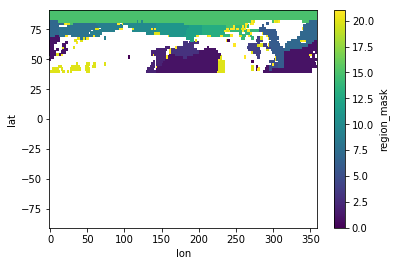

In [32]:
reg_filename = '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/analysis/regionmask_surfaceareacell_2x2_grid.nc'
reg_mask = xr.open_dataset(reg_filename)
reg_mask.region_mask.plot()

In [471]:
# 0 Ice-free Oceans
# 1 Sea of Okhotsk 
# 2 Bering         
# 3 Hudson Bay     
# 4 St John        
# 5 Baffin Bay     
# 6 East Greeland S
# 7 Barents Sea    
# 8 Kara Sea       
# 9 Laptev Sea     
# 10 East Siberian S
# 11 Chukchi Sea    
# 12 Beaufort Sea   
# 13 Canadian Island
# 14 Central Arctic 
# 15 null           
# 16 null           
# 17 null           
# 18 null           
# 19 land           
# 20 land outline 

In [472]:
hudbay_mask = reg_mask.cell_area.where(reg_mask.region_mask==8)/(1e6)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


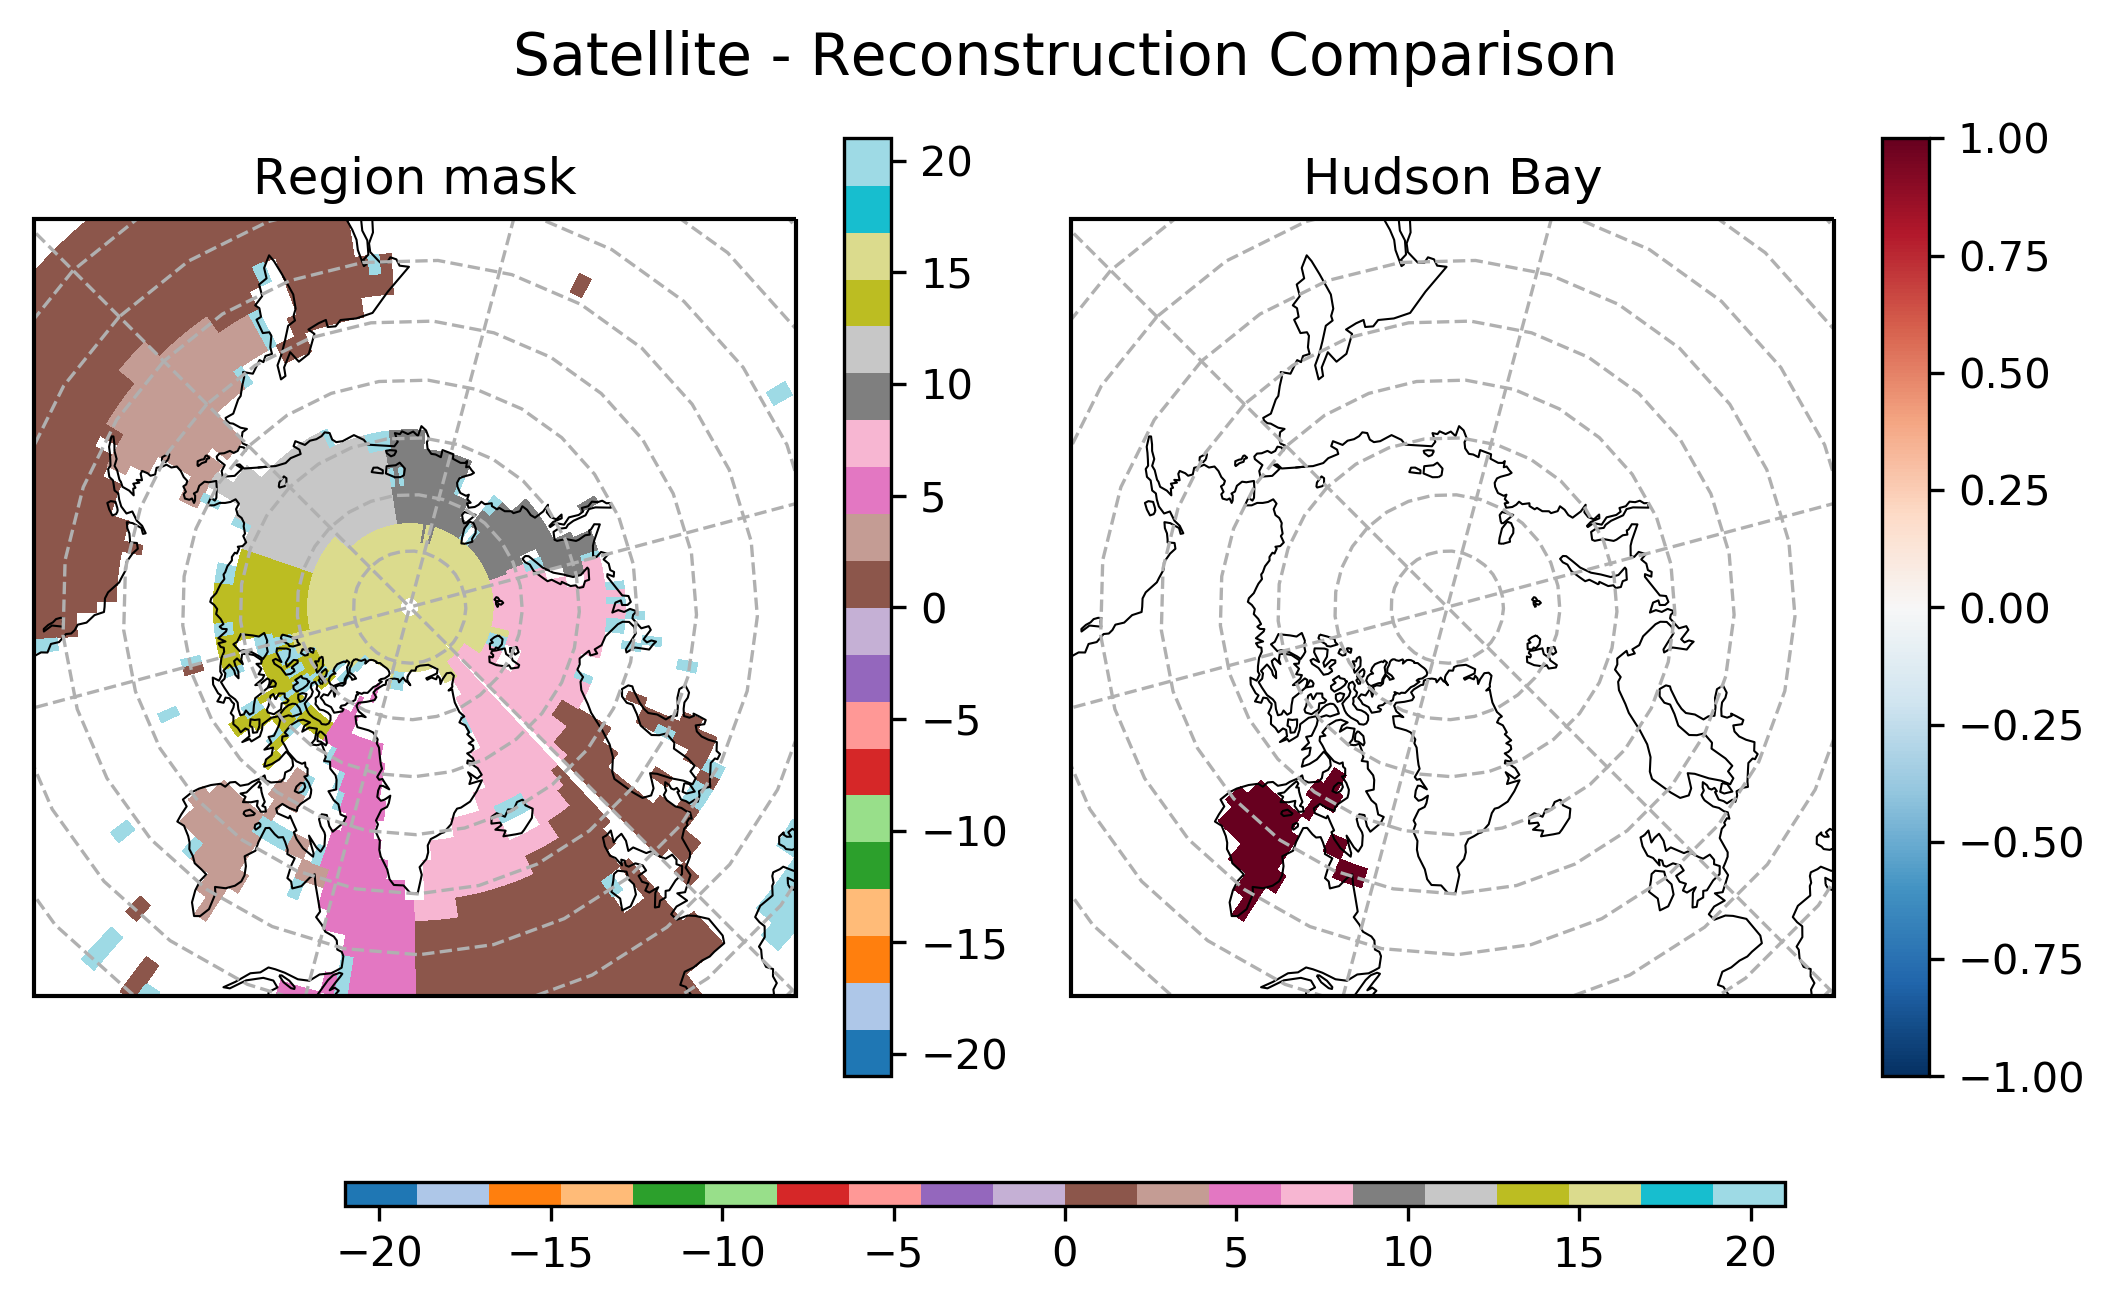

In [394]:
fig,ax = plt.subplots(1,2, figsize=(8, 4), subplot_kw = proj)
ax = ax.flatten()

cs = sub_arctic_plot(fig,ax[0],reg_mask.region_mask.values,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],
                     'Region mask',21, CMAP=plt.cm.tab20,colorbar=True)
cs1 = sub_arctic_plot(fig,ax[1],hudbay_mask,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],
                      'Hudson Bay',1, colorbar=True)

position=fig.add_axes([0.15,0.0,0.6,0.02])
cb = plt.colorbar(cs, cax=position, orientation='horizontal')

fig.suptitle('Satellite - Reconstruction Comparison', fontsize=14, x=0.45)
plt.tight_layout(rect=(0,0.05,0.90,0.94))
#plt.savefig(savedir+savename, bbox_inches='tight')

## Load Walsh regional data: 

In [42]:
walsh_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/Walsh2016/walsh_comparison/'
walsh_file = 'Walsh_annual_regional_means_sia_sie_km2.npz'
walsh_all_file = 'Walsh_annual_all_regional_means_sia_sie_km2.npz'

walsh_ds = np.load(walsh_dir+walsh_file)

In [43]:
walsh_time = walsh_ds['Walsh_years']
walsh_ind = np.where((walsh_time>=anom_start)&(walsh_time<=anom_end))

walsh_greenland_sia = walsh_ds['Greenland_sea_sia_anmn'] - np.nanmean(walsh_ds['Greenland_sea_sia_anmn'][walsh_ind])
walsh_hudbay_sia = walsh_ds['Hudson_bay_sea_sia_anmn'] - np.nanmean(walsh_ds['Hudson_bay_sea_sia_anmn'][walsh_ind])
walsh_barents_sia = walsh_ds['Barents_sea_sia_anmn'] - np.nanmean(walsh_ds['Barents_sea_sia_anmn'][walsh_ind])
walsh_canarch_sia = walsh_ds['CanArch_sea_sia_anmn'] - np.nanmean(walsh_ds['CanArch_sea_sia_anmn'][walsh_ind])
walsh_chukchi_sia = walsh_ds['Chukchi_sea_sia_anmn'] - np.nanmean(walsh_ds['Chukchi_sea_sia_anmn'][walsh_ind])

walsh_greenland_sie = walsh_ds['Greenland_sea_sie_anmn'] - np.nanmean(walsh_ds['Greenland_sea_sie_anmn'][walsh_ind])
walsh_hudbay_sie = walsh_ds['Hudson_bay_sea_sie_anmn'] - np.nanmean(walsh_ds['Hudson_bay_sea_sie_anmn'][walsh_ind])
walsh_barents_sie = walsh_ds['Barents_sea_sie_anmn'] - np.nanmean(walsh_ds['Barents_sea_sie_anmn'][walsh_ind])
walsh_canarch_sie = walsh_ds['CanArch_sea_sie_anmn'] - np.nanmean(walsh_ds['CanArch_sea_sie_anmn'][walsh_ind])
walsh_chukchi_sie = walsh_ds['Chukchi_sea_sie_anmn'] - np.nanmean(walsh_ds['Chukchi_sea_sie_anmn'][walsh_ind])

In [44]:
walsh_all_ds = np.load(walsh_dir+walsh_all_file)
walsh_ind = np.where((walsh_time>=anom_start)&(walsh_time<=anom_end))

walsh_years = walsh_all_ds['Walsh_years']
walsh_regional_sia = {}
walsh_regional_sie = {}

walsh_regional_sia['Beaufort Sea'] = walsh_all_ds['Beaufort_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Beaufort_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Chukchi Sea'] = walsh_all_ds['Chukchi_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Chukchi_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['East Siberian Sea'] = walsh_all_ds['Siberian_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Siberian_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Laptev Sea'] = walsh_all_ds['Laptev_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Laptev_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Kara Sea'] = walsh_all_ds['Kara_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Kara_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Barents Sea'] = walsh_all_ds['Barents_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Barents_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['East Greenland Sea'] = walsh_all_ds['Greenland_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Greenland_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Baffin Bay'] = walsh_all_ds['Baffin_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Baffin_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Canadian Archipelago'] = walsh_all_ds['CanArch_sea_sia_anmn'] - np.nanmean(walsh_all_ds['CanArch_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Hudson Bay'] = walsh_all_ds['Hudson_bay_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Hudson_bay_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Central Arctic'] = walsh_all_ds['Centralarctic_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Centralarctic_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Baltic Sea'] = walsh_all_ds['Baltic_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Baltic_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Bering Sea'] = walsh_all_ds['Bering_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Bering_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Sea of Okhotsk'] = walsh_all_ds['Okhotsk_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Okhotsk_sea_sia_anmn'][walsh_ind])

In [46]:
East Greenland Sea
East Greenland Seas

KeyError: 'East Greenland Seas'

## Reconstructions - regional totals: 

In [ ]:
# 0 Ice-free Oceans
# 1 Sea of Okhotsk 
# 2 Bering         
# 3 Hudson Bay     
# 4 St John        
# 5 Baffin Bay     
# 6 East Greeland S
# 7 Barents Sea    
# 8 Kara Sea       
# 9 Laptev Sea     
# 10 East Siberian S
# 11 Chukchi Sea    
# 12 Beaufort Sea   
# 13 Canadian Island
# 14 Central Arctic 
# 15 null           
# 16 null           
# 17 null           
# 18 null           
# 19 land           
# 20 land outline 

In [47]:
regions = ['Sea of Okhotsk','Bering Sea','Hudson Bay','St John','Baffin Bay',
           'East Greenland Sea','Barents Sea','Kara Sea','Laptev Sea','East Siberian Sea',
           'Chukchi Sea','Beaufort Sea','Canadian Archipelago','Central Arctic']

In [18]:
ccsm4_sic_enmn = np.nanmean(sic_lalo_allit_ccsm4,axis=3)/100
ccsm4_sie_enmn = np.where(ccsm4_sic_enmn>=0.15,1.0,0.0)

In [19]:
ccsm4_sic = np.moveaxis(sic_lalo_allit_ccsm4, 3, 0)/100
ccsm4_sie = np.where(ccsm4_sic>=0.15,1.0,0.0)

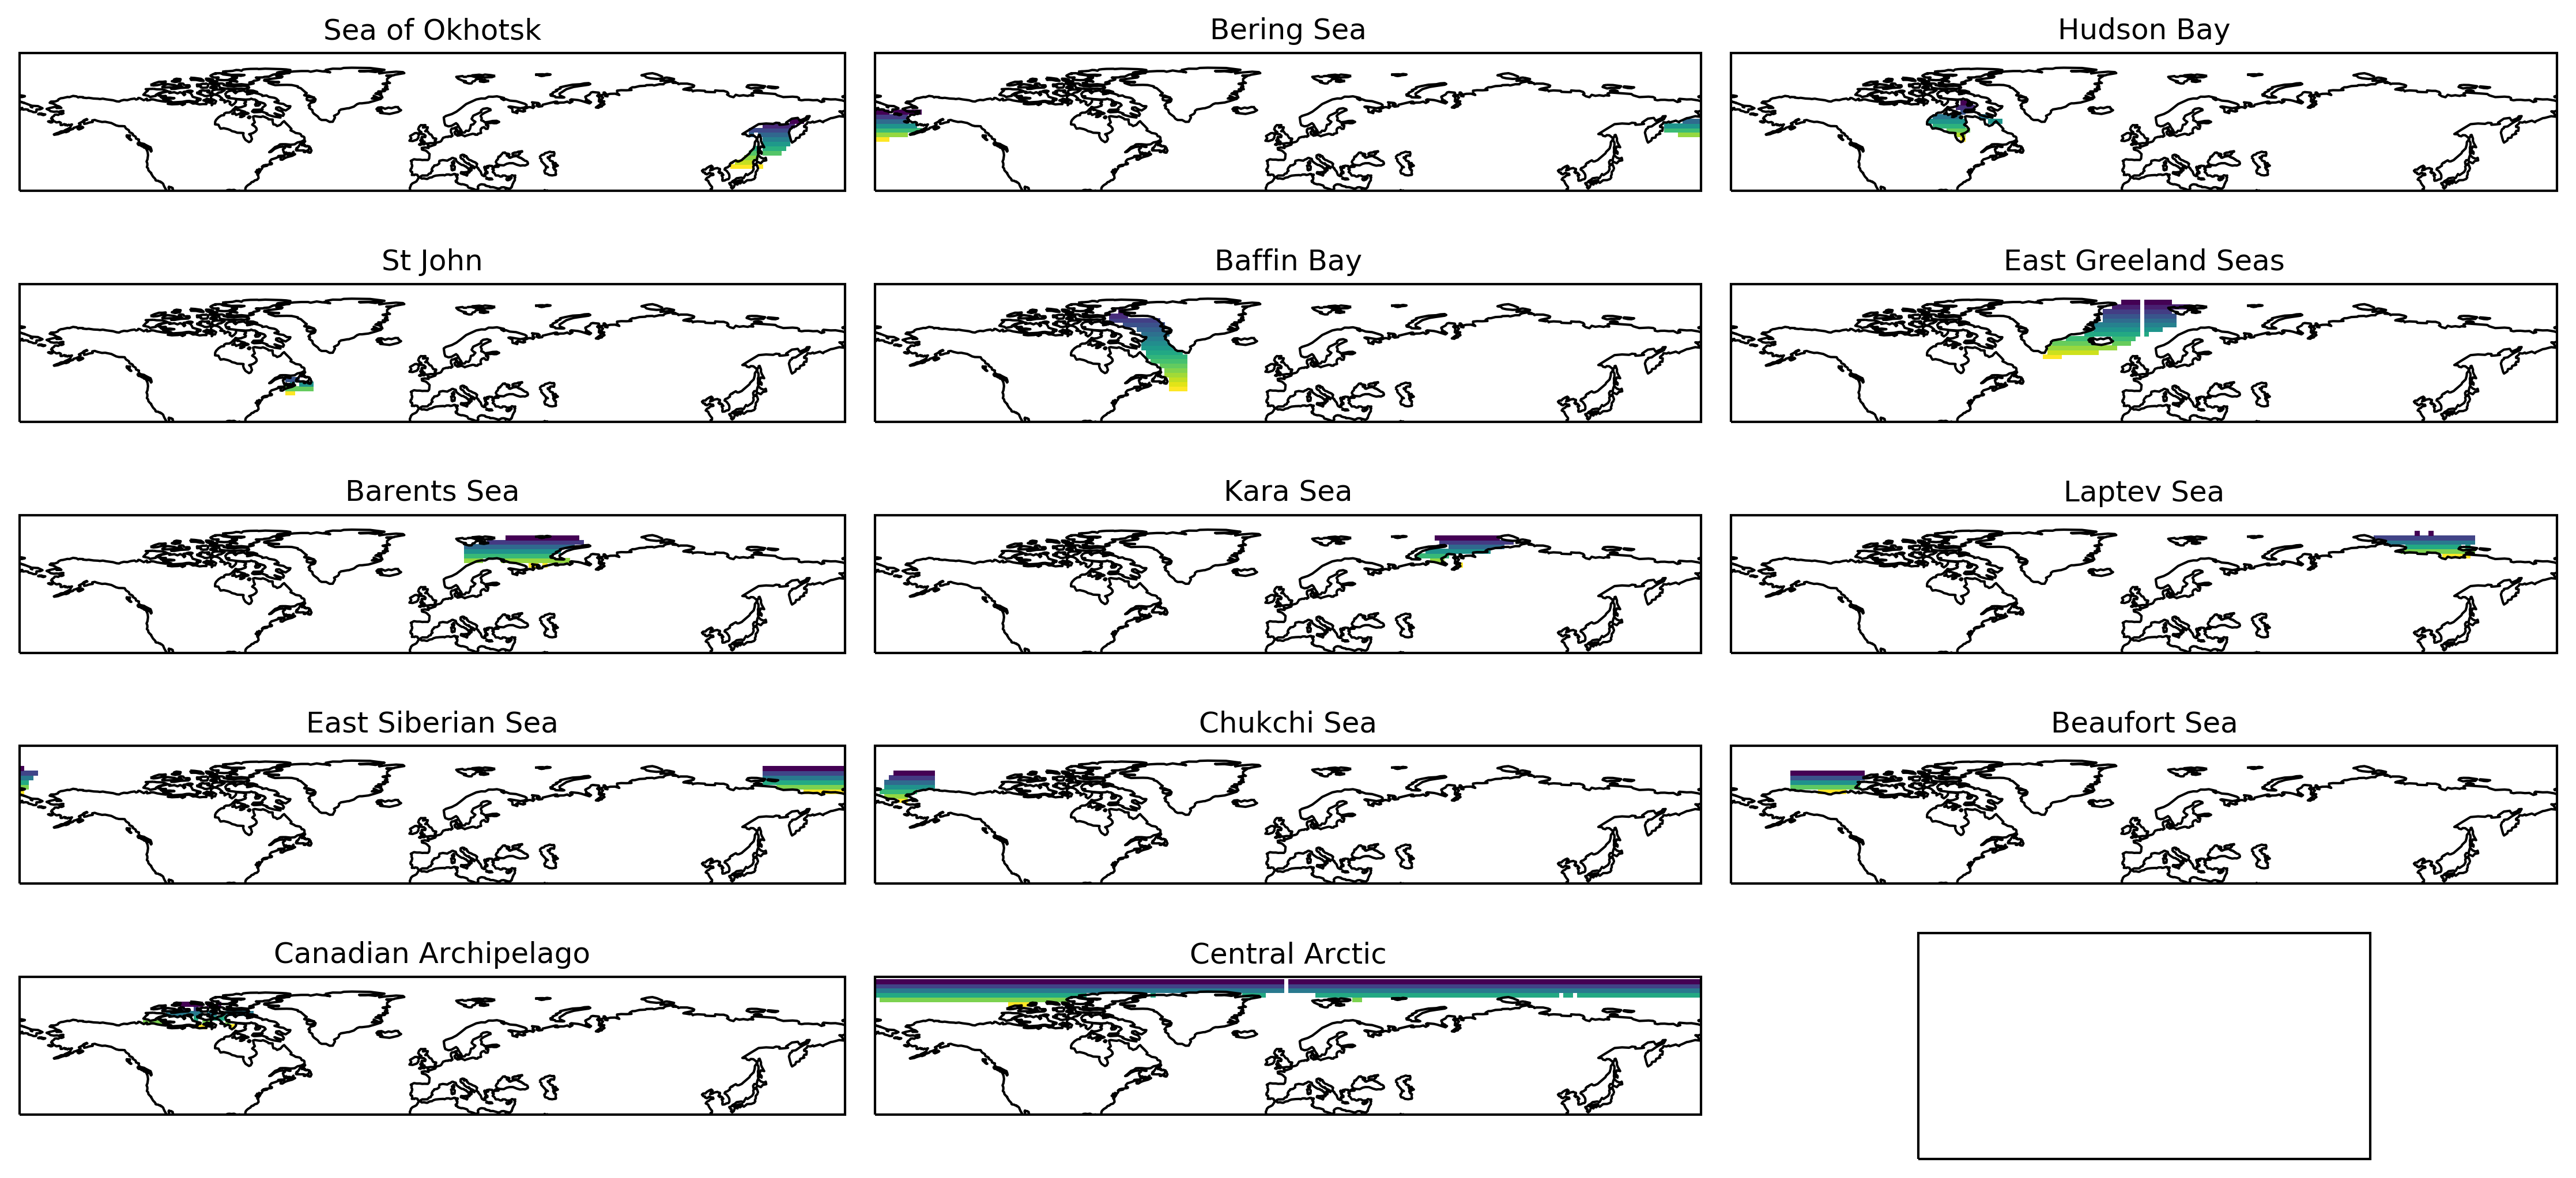

In [479]:
import cartopy.crs as ccrs
fig, ax = plt.subplots(5,3, figsize=(15,7),subplot_kw=dict(projection=ccrs.PlateCarree()))
ax=ax.flatten()

for i,reg in enumerate(regions): 
    ax[i].pcolormesh(ccsm4_truth_lon[0,:],ccsm4_truth_lat[:,0],regional_masks[reg],transform=ccrs.PlateCarree())
    ax[i].coastlines()
    ax[i].set_title(reg, fontsize=12)
    ax[i].set_ylim(30,90)
    
plt.tight_layout()

In [48]:
regional_masks = {}

regional_masks['Sea of Okhotsk'] = reg_mask.cell_area.where(reg_mask.region_mask==2)/(1e6)
regional_masks['Bering Sea'] = reg_mask.cell_area.where(reg_mask.region_mask==3)/(1e6)
regional_masks['Hudson Bay'] = reg_mask.cell_area.where(reg_mask.region_mask==4)/(1e6)
regional_masks['St John'] = reg_mask.cell_area.where(reg_mask.region_mask==5)/(1e6)
regional_masks['Baffin Bay'] = reg_mask.cell_area.where(reg_mask.region_mask==6)/(1e6)
regional_masks['East Greenland Sea'] = reg_mask.cell_area.where(reg_mask.region_mask==7)/(1e6)
regional_masks['Barents Sea'] = reg_mask.cell_area.where(reg_mask.region_mask==8)/(1e6)
regional_masks['Kara Sea'] = reg_mask.cell_area.where(reg_mask.region_mask==9)/(1e6)
regional_masks['Laptev Sea'] = reg_mask.cell_area.where(reg_mask.region_mask==10)/(1e6)
regional_masks['East Siberian Sea'] = reg_mask.cell_area.where(reg_mask.region_mask==11)/(1e6)
regional_masks['Chukchi Sea'] = reg_mask.cell_area.where(reg_mask.region_mask==12)/(1e6)
regional_masks['Beaufort Sea'] = reg_mask.cell_area.where(reg_mask.region_mask==13)/(1e6)
regional_masks['Canadian Archipelago'] = reg_mask.cell_area.where(reg_mask.region_mask==14)/(1e6)
regional_masks['Central Arctic'] = reg_mask.cell_area.where(reg_mask.region_mask==15)/(1e6)

In [481]:
reg_mask.region_mask.where(reg_mask.region_mask==11)

<xarray.DataArray 'region_mask' (lat: 91, lon: 180)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float32 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0

In [443]:
reg_mask.lat

<xarray.DataArray 'lat' (lat: 91)>
array([-90., -88., -86., -84., -82., -80., -78., -76., -74., -72., -70., -68.,
       -66., -64., -62., -60., -58., -56., -54., -52., -50., -48., -46., -44.,
       -42., -40., -38., -36., -34., -32., -30., -28., -26., -24., -22., -20.,
       -18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,
         6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,  24.,  26.,  28.,
        30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,  48.,  50.,  52.,
        54.,  56.,  58.,  60.,  62.,  64.,  66.,  68.,  70.,  72.,  74.,  76.,
        78.,  80.,  82.,  84.,  86.,  88.,  90.], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0

In [49]:
def calc_regional_totals(ccsm4_sic, ccsm4_sie, mask, recon_years, anom_start, anom_end):
    regional_sic = np.nansum(np.nansum((ccsm4_sic*mask),axis=3),axis=2)
    regional_sie = np.nansum(np.nansum((ccsm4_sie*mask),axis=3),axis=2)

    regional_sic_ensmn = np.nanmean(regional_sic,axis=0)
    regional_sie_ensmn = np.nanmean(regional_sie,axis=0)

    regional_sic_high = np.percentile(regional_sic,97.5,axis=0)
    regional_sic_low = np.percentile(regional_sic,2.5,axis=0)
    regional_sie_high = np.percentile(regional_sie,97.5,axis=0)
    regional_sie_low = np.percentile(regional_sie,2.5,axis=0)

    anom_ind = (np.array(recon_years)>=anom_start)&(np.array(recon_years)<=anom_end)

    regional_sie_anom = (regional_sie_ensmn - np.nanmean(regional_sie_ensmn[anom_ind]))/1e6
    regional_sic_anom = (regional_sic_ensmn - np.nanmean(regional_sic_ensmn[anom_ind]))/1e6

    regional_sie_lowanom = (regional_sie_low - np.nanmean(regional_sie_ensmn[anom_ind]))/1e6
    regional_sie_highanom = (regional_sie_high - np.nanmean(regional_sie_ensmn[anom_ind]))/1e6
    regional_sic_highanom = (regional_sic_high - np.nanmean(regional_sic_ensmn[anom_ind]))/1e6
    regional_sic_lowanom = (regional_sic_low - np.nanmean(regional_sic_ensmn[anom_ind]))/1e6
    
    return (regional_sie_anom,regional_sie_lowanom,regional_sie_highanom,
            regional_sic_anom,regional_sic_lowanom,regional_sic_highanom)

In [50]:
regional_sie_anom = {}
regional_sie_lowanom = {}
regional_sie_highanom = {}
regional_sic_anom = {}
regional_sic_lowanom = {}
regional_sic_highanom = {}

for reg in regions:
    print('Working on '+reg+'...')
    [regional_sie_anom[reg],regional_sie_lowanom[reg],
     regional_sie_highanom[reg],regional_sic_anom[reg],
     regional_sic_lowanom[reg],
     regional_sic_highanom[reg]] = calc_regional_totals(ccsm4_sic,ccsm4_sie, regional_masks[reg].values, 
                                                        recon_years, anom_start, anom_end)
    

Working on Sea of Okhotsk...
Working on Bering Sea...
Working on Hudson Bay...
Working on St John...
Working on Baffin Bay...
Working on East Greenland Sea...
Working on Barents Sea...
Working on Kara Sea...
Working on Laptev Sea...
Working on East Siberian Sea...
Working on Chukchi Sea...
Working on Beaufort Sea...
Working on Canadian Archipelago...
Working on Central Arctic...


In [52]:
ce_walsh_ccsm4_allregions = {}
corr_walsh_ccsm4_allregions = {}
regions_both = ['Sea of Okhotsk','Bering Sea','Hudson Bay','Baffin Bay',
                'East Greenland Sea','Barents Sea','Kara Sea','Laptev Sea','East Siberian Sea',
                'Chukchi Sea','Beaufort Sea','Canadian Archipelago','Central Arctic']

for reg in regions_both: 
    print('Working on '+reg+'...')
    [ce_walsh_ccsm4_allregions[reg],
     corr_walsh_ccsm4_allregions[reg],_,_] = rrutils.find_ce_corr(walsh_regional_sia[reg], 
                                                                  regional_sic_anom[reg],
                                                                  np.array(recon_years),
                                                                  walsh_time,1850,1999)
    
    print('R^2 = '+str(np.round(corr_walsh_ccsm4_allregions[reg]**2,2)))
    print('CE = '+str(np.round(ce_walsh_ccsm4_allregions[reg],2))+'\n')

Working on Sea of Okhotsk...
R^2 = 0.02
CE = -10.96

Working on Bering Sea...
R^2 = 0.25
CE = -0.2

Working on Hudson Bay...
R^2 = 0.17
CE = -0.4

Working on Baffin Bay...
R^2 = 0.0
CE = -2.97

Working on East Greenland Sea...
R^2 = 0.02
CE = -0.6

Working on Barents Sea...
R^2 = 0.12
CE = -0.36

Working on Kara Sea...
R^2 = 0.15
CE = -1.3

Working on Laptev Sea...
R^2 = 0.09
CE = -8.56

Working on East Siberian Sea...
R^2 = 0.07
CE = -1.26

Working on Chukchi Sea...
R^2 = 0.28
CE = 0.03

Working on Beaufort Sea...
R^2 = 0.12
CE = -0.37

Working on Canadian Archipelago...
R^2 = 0.01
CE = -24.03

Working on Central Arctic...
R^2 = 0.01
CE = -6.59



In [53]:
Wn2 = 1.0/15
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


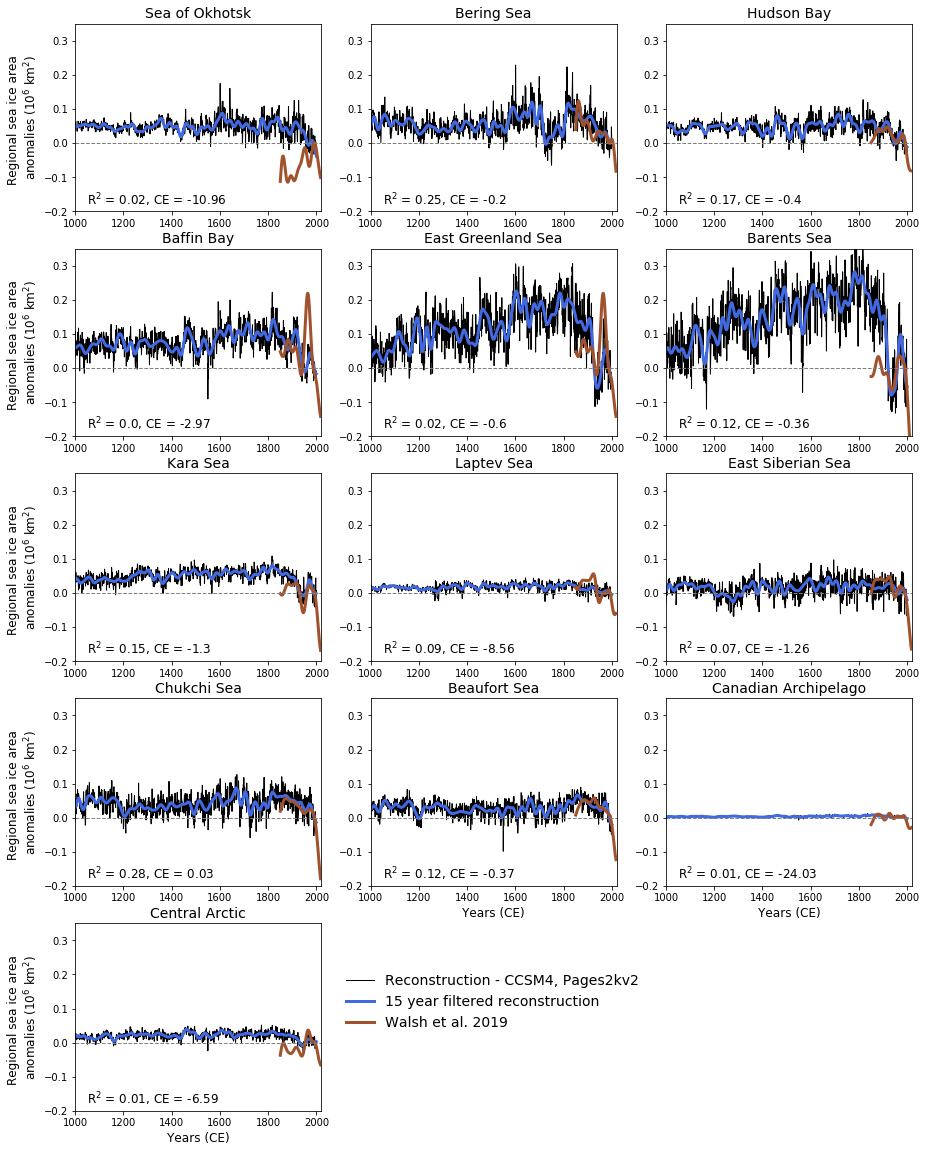

In [56]:
fig, ax = plt.subplots(5,3, figsize=(15,20))
ax[4,2].set_axis_off()
ax[4,1].set_axis_off()
ax = ax.flatten()


for i,reg in enumerate(regions_both): 
    walsh_filt15 =  signal.filtfilt(b2,a2,walsh_regional_sia[reg])
    recon_filt15 =  signal.filtfilt(b2,a2,regional_sic_anom[reg])
    
    ax[i].plot(np.array(recon_years),regional_sic_anom[reg], color='k', linewidth=1, 
               label='Reconstruction - CCSM4, Pages2kv2')
    ax[i].plot(np.array(recon_years), recon_filt15, color='royalblue', linewidth=3, 
              label = '15 year filtered reconstruction')
    
    ax[i].plot(walsh_years,walsh_filt15, color='sienna',linewidth=3, label = 'Walsh et al. 2019')
    
    ax[i].axhline(0,color='gray', linestyle='--', linewidth=1)
    if i in [0,3,6,9,12]:
        ax[i].set_ylabel('Regional sea ice area \nanomalies (10$^6$ km$^2$)', fontsize=12)
        
    if i is 12: 
        ax[i].legend(bbox_to_anchor=[1.05,0.8], fontsize=14, frameon=False)
  
    ax[i].set_xlim(1000,2020)
    ax[i].set_ylim(-0.2,0.35)
    ax[i].set_title(reg, fontsize=14)
    ax[i].text(1050, -0.18,('R$^2$ = '+str(np.round(corr_walsh_ccsm4_allregions[reg]**2,2)) + 
               ', CE = '+str(np.round(ce_walsh_ccsm4_allregions[reg],2))), fontsize=12)
    
ax[12].set_xlabel('Years (CE)',fontsize=12)
ax[11].set_xlabel('Years (CE)',fontsize=12)
ax[10].set_xlabel('Years (CE)',fontsize=12)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Regional_comparison_ccsm4_walsh_all_regions.png'
plt.savefig(savedir+savename)

# Proxy comparisons: 

In [59]:
data_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/si_proxy_records/'

## Halfar et al. 2013 - Canadian Arctic: 

In [60]:
Halfar_file = 'Halfar_etal_2013.csv'

# Site Information
#       Site_Name: Arctic Northwest Atlantic
#       Location: Ocean>Atlantic Ocean>North Atlantic Ocean
#       Northernmost_Latitude: 73.0174
#       Southernmost_Latitude: 55.3983
#       Easternmost_Longitude: -59.8467
#       Westernmost_Longitude: -85.1536
#       Elevation: -17

halfar_ds = pd.read_csv(data_dir+Halfar_file,delimiter = "\t",skiprows=83)
halfar_ds.head()

age_AD   SIC
0    2010  0.65
1    2009 -0.97
2    2008  0.42
3    2007  1.25
4    2006  0.21

In [61]:
halfar_sic = halfar_ds['SIC'].values
halfar_time = halfar_ds['age_AD'].values

In [62]:
halfar_sic_5ymn = np.zeros(halfar_sic.shape[0]-4)
start = 2

for t in range(halfar_sic_5ymn.shape[0]):
    halfar_sic_5ymn[t] = np.nanmean(halfar_sic[start-2:start+3],axis=0)
    start=start+1

NameError: name 'halfar_sic_filt15' is not defined

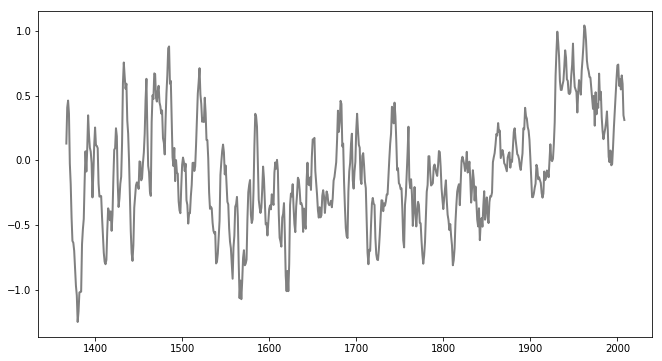

In [63]:
fig, ax_recon = plt.subplots(1, figsize=(11,6))

#plt.plot(halfar_time, halfar_sic)
plt.plot(halfar_time[2:-2], halfar_sic_5ymn, color='gray',linewidth=2)
plt.plot(halfar_time, halfar_sic_filt15,color='crimson', linewidth=2)

plt.ylim(1.5,-1.5)

ax_recon.spines['top'].set_visible(False)
ax_recon.spines['right'].set_visible(False)

plt.ylabel('Algal proxy anomalies', fontsize=14)
plt.title('Halfar et al. 2013', fontsize=14)

ax_recon.yaxis.set_minor_locator(MultipleLocator(0.25))
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))

In [57]:
['Sea of Okhotsk','Bering Sea','Hudson Bay','Baffin Bay',
                'East Greenland Sea','Barents Sea','Kara Sea','Laptev Sea','East Siberian Sea',
                'Chukchi Sea','Beaufort Sea','Canadian Archipelago','Central Arctic']

['Sea of Okhotsk',
 'Bering Sea',
 'Hudson Bay',
 'Baffin Bay',
 'East Greenland Sea',
 'Barents Sea',
 'Kara Sea',
 'Laptev Sea',
 'East Siberian Sea',
 'Chukchi Sea',
 'Beaufort Sea',
 'Canadian Archipelago',
 'Central Arctic']

In [64]:
Wn2 = 1.0/15
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)

halfar_sic_filt15 =  signal.filtfilt(b2,a2,halfar_sic)
canarch_sic_filt15 = signal.filtfilt(b2,a2,regional_sic_anom['Canadian Archipelago'])
hudbay_sic_filt15 = signal.filtfilt(b2,a2,regional_sic_anom['Hudson Bay'])
baffin_sic_filt15 = signal.filtfilt(b2,a2,regional_sic_anom['Baffin Bay'])
hudbay_walsh_filt20 = signal.filtfilt(b2,a2,walsh_regional_sia['Hudson Bay'])
canarch_walsh_filt20 = signal.filtfilt(b2,a2,walsh_regional_sia['Canadian Archipelago'])
baffin_walsh_filt20 = signal.filtfilt(b2,a2,walsh_regional_sia['Baffin Bay'])

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


NameError: name 'canarch_sic_lowanom' is not defined

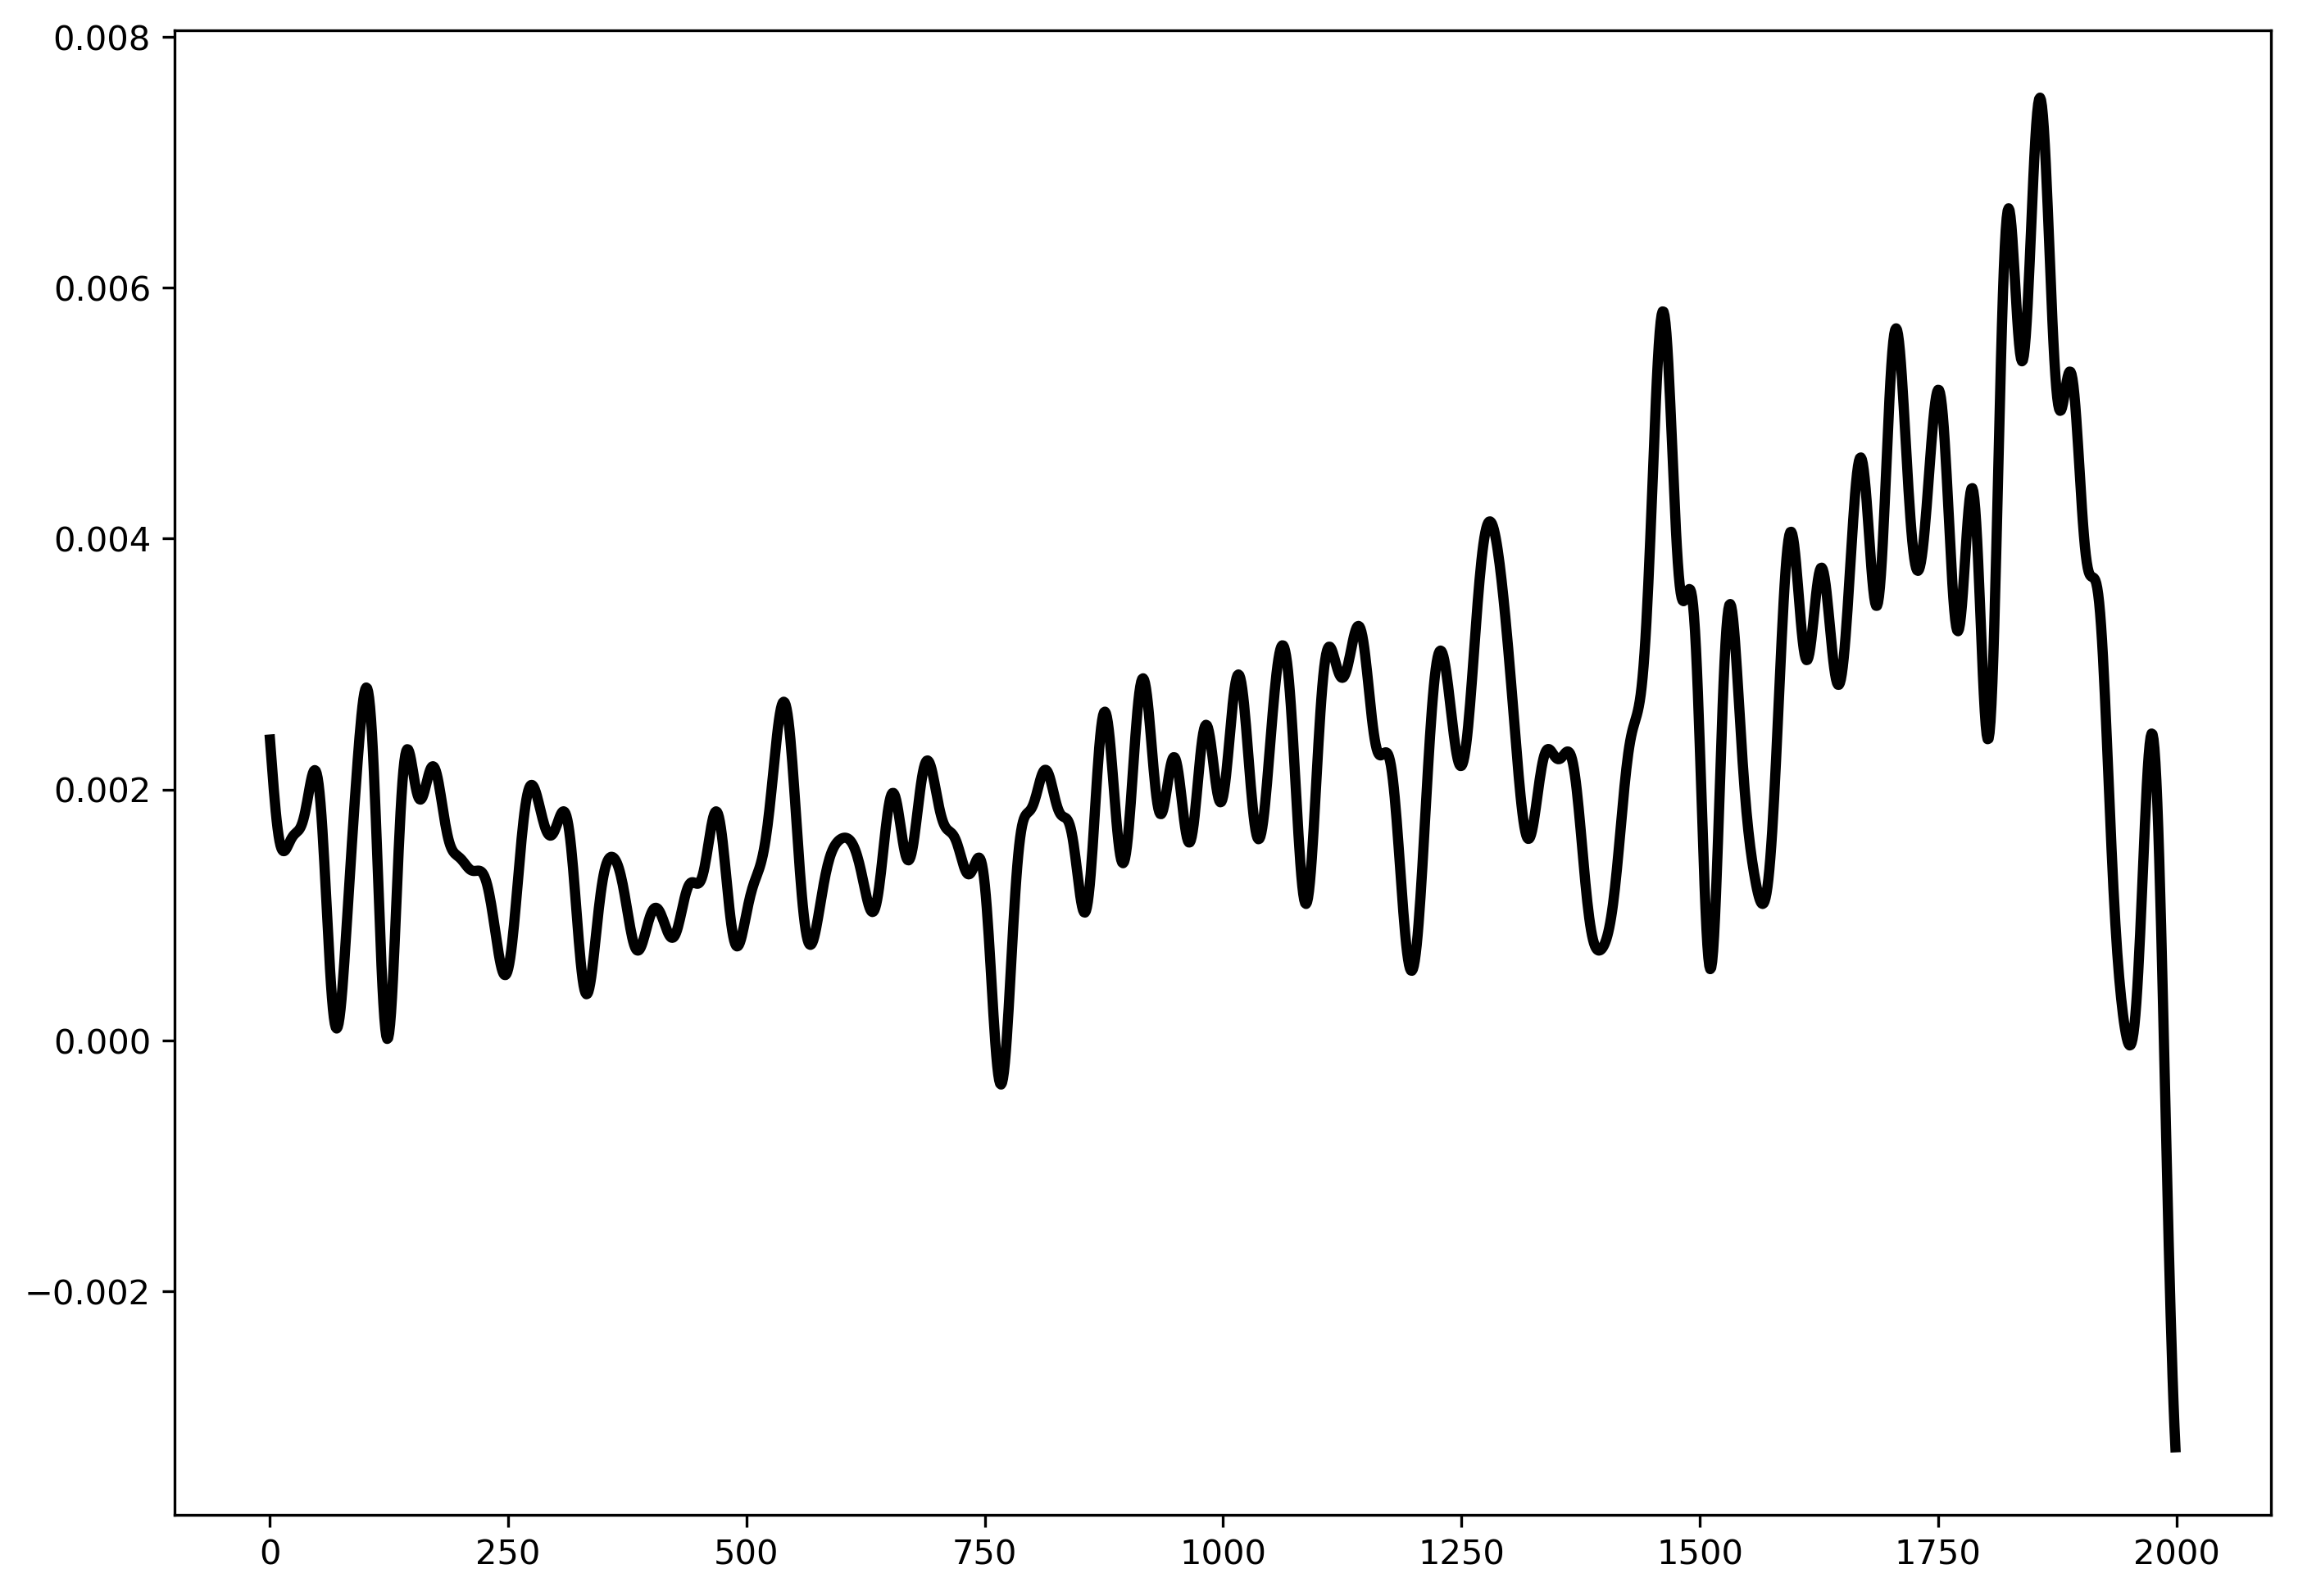

In [489]:
fig, ax_recon = plt.subplots(1, figsize=(11,8))

# plt.plot(np.flip(kinnard_years[9:]), canarch_sic_anom[min_yr:], color='k',linewidth=2,
#          label='Reconstruction - \nCCSM4, Pages2k')
plt.plot(np.array(recon_years), canarch_sic_filt15, color='k',linewidth=3,
         label='Reconstruction - \nCanadian Archipelago')
plt.fill_between(np.array(recon_years),canarch_sic_lowanom,
                 canarch_sic_highanom,color='gray',alpha=0.5, edgecolor=None)

# plt.plot(np.flip(kinnard_years[9:]), hudbay_sic_anom[min_yr:], 
#          color='k',linewidth=2,label='Reconstruction - \nCCSM4, Pages2k')
plt.plot(np.array(recon_years), hudbay_sic_filt15, 
         color='navy',linewidth=3,label='Reconstruction - \nBaffin and Hudson Bays')
plt.fill_between(np.array(recon_years),hudbay_sic_lowanom,
                 hudbay_sic_highanom,color='navy',alpha=0.2, edgecolor=None)

plt.plot(walsh_time, hudbay_walsh_filt20, color='sienna',linewidth=4,
         label='Walsh et al. 2019')
# plt.plot(walsh_time, canarch_walsh_filt20, color='gray',linewidth=4,
#          label='Walsh et al. 2019')

ax_proxy = ax_recon.twinx()
plt.plot(halfar_time[2:-2], halfar_sic_5ymn, color='olive',linewidth=2, alpha=0.4)
plt.plot(halfar_time, halfar_sic_filt15, color='olive',linewidth=3, label='Halfar et al. 2013')

#plt.ylim(1.5,-1.5)

ax_proxy.set_ylim(4.1,-1.5)
ax_recon.set_ylim(-0.1,0.35)
ax_proxy.set_xlim(1000,2020)
ax_recon.set_xlim(1000,2020)

ax_recon.spines['top'].set_visible(False)
ax_proxy.spines['top'].set_visible(False)

ax_recon.set_yticks(np.arange(-0.05,0.16,0.05))
ax_proxy.set_yticks(np.arange(-1.0,1.1,0.5))

ax_proxy.set_ylabel('Algal proxy anomalies \n more sea ice $\longrightarrow$', fontsize=14)
ax_recon.set_ylabel('Regional sea ice area (10$^6$ km$^2$)', fontsize=14)
plt.title('Canadian Arctic: Regional Comparison', fontsize=16)

ax_proxy.yaxis.set_label_coords(1.06, 0.75)
ax_recon.yaxis.set_label_coords(-0.06, 0.33)

ax_proxy.yaxis.label.set_color('olive')
ax_proxy.tick_params(axis='y', colors='olive')

ax_proxy.legend(bbox_to_anchor=[0.305,0.76],frameon=False, fontsize=14)
ax_recon.legend(bbox_to_anchor=[0.38,0.71],frameon=False, fontsize=14)

#ax_recon.yaxis.set_minor_locator(MultipleLocator(2.5))
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))

In [65]:
# [ce_hudbay_walsh_ccsm4,
#  corr_hudbay_walsh_ccsm4,_,_] = rrutils.find_ce_corr(walsh_hudbay_sia, 
#                                                      hudbay_sic_anom,
#                                                      np.array(recon_years),
#                                                      walsh_time,1850,1999)

[ce_hudbay_walsh_ccsm4,
 corr_hudbay_walsh_ccsm4,_,_] = rrutils.find_ce_corr(walsh_regional_sia['Baffin Bay'], 
                                                     regional_sic_anom['Baffin Bay'],
                                                     np.array(recon_years),
                                                     walsh_time,1850,1999)

# [ce_hudbay_walsh_ccsm4,
#  corr_hudbay_walsh_ccsm4,_,_] = rrutils.find_ce_corr(baffin_walsh_filt20, 
#                                                      baffin_sic_filt15,
#                                                      np.array(recon_years),
#                                                      walsh_time,1850,1999)

ce_hudbay_walsh_ccsm4,corr_hudbay_walsh_ccsm4**2

(-2.9659042919709173, 0.0026238992388403423)

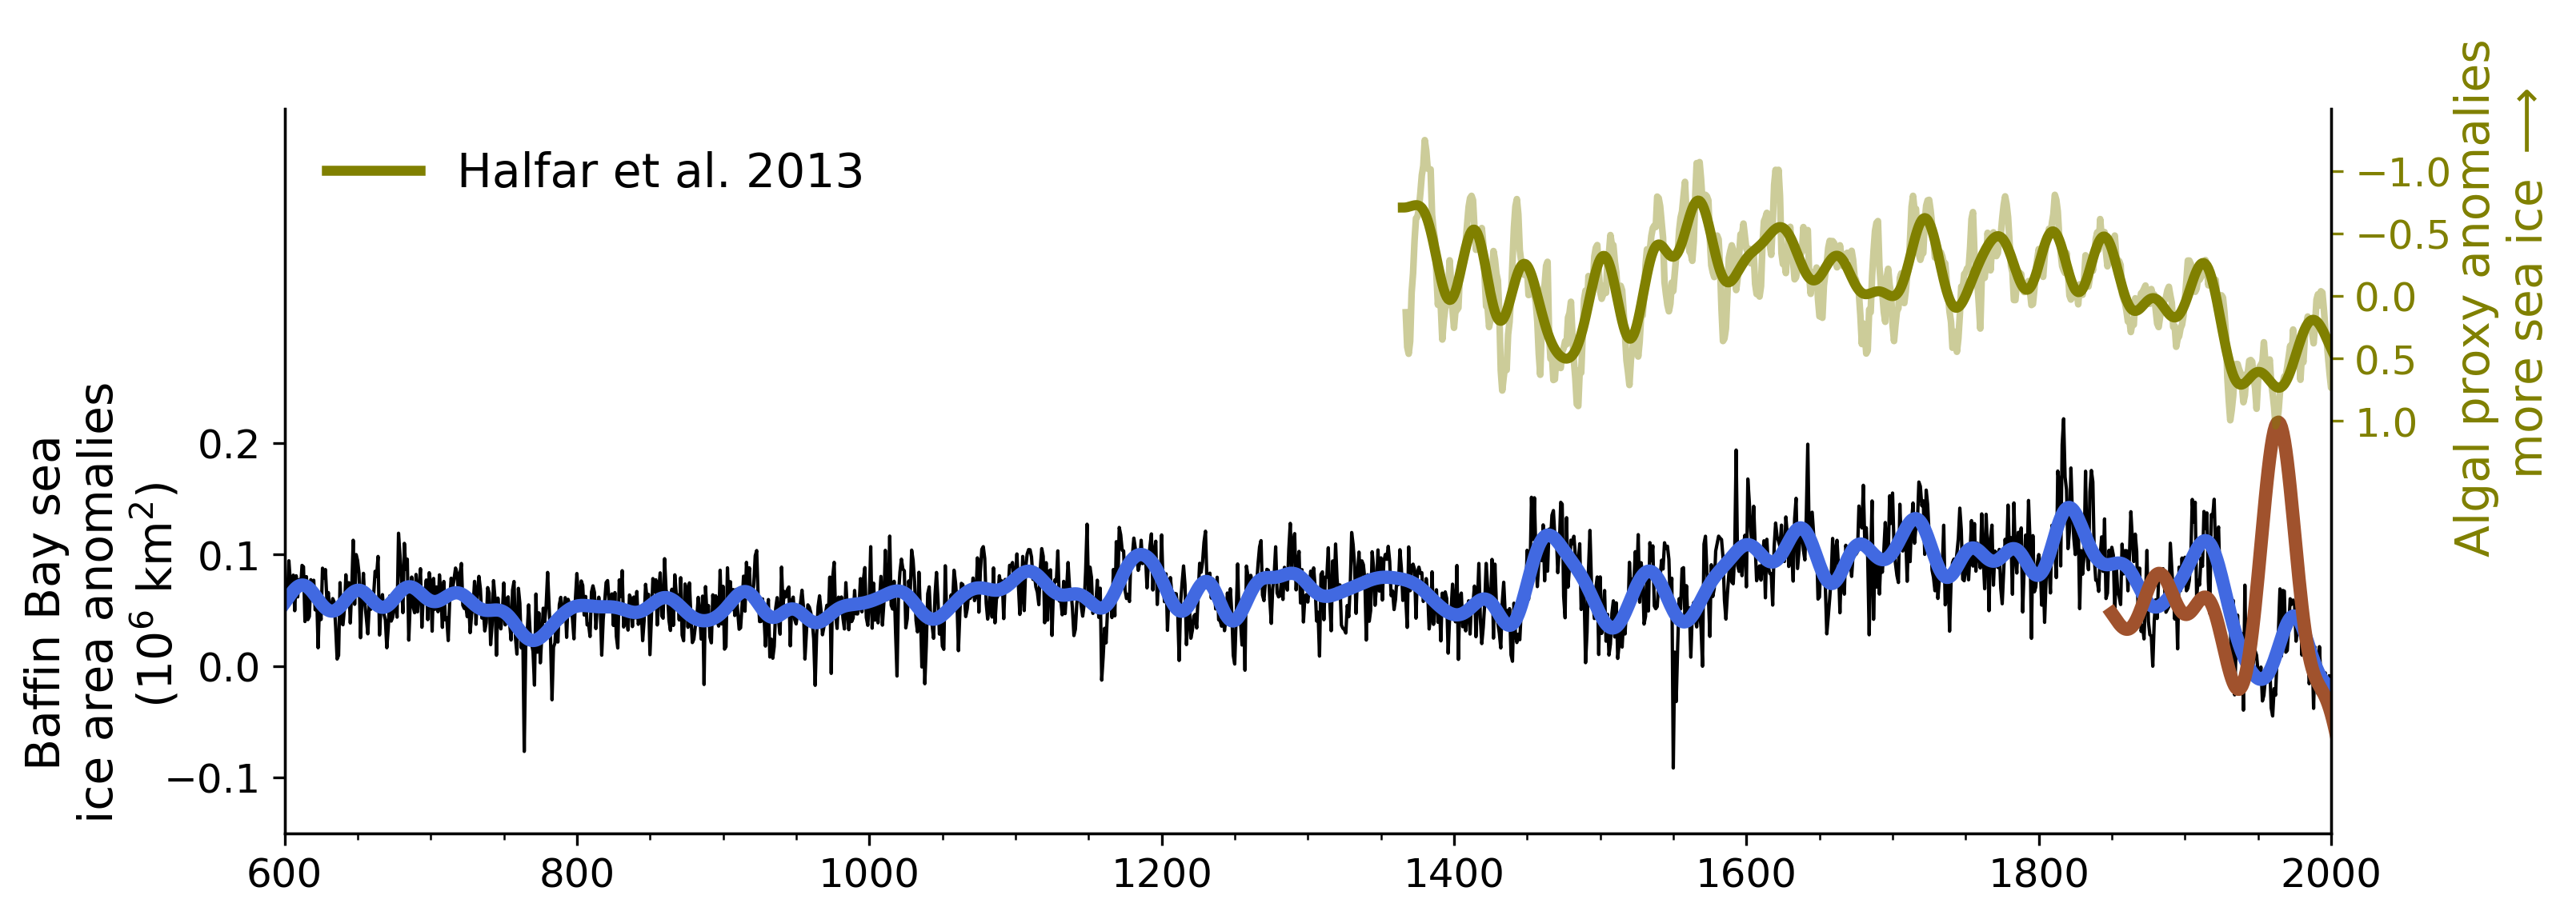

In [118]:
fig, ax_recon = plt.subplots(1, figsize=(11,4))

# plt.plot(np.flip(kinnard_years[9:]), canarch_sic_anom[min_yr:], color='k',linewidth=2,
#          label='Reconstruction - \nCCSM4, Pages2k')
# plt.plot(np.array(recon_years), canarch_sic_filt15, color='k',linewidth=3,
#          label='Reconstruction - \nCanadian Archipelago')
# plt.fill_between(np.array(recon_years),canarch_sic_lowanom,
#                  canarch_sic_highanom,color='gray',alpha=0.5, edgecolor=None)

plt.plot(np.array(recon_years), regional_sic_anom['Baffin Bay'], 
         color='k',linewidth=1,label='Reconstruction - \nCCSM4, Pages2k')
plt.plot(np.array(recon_years), baffin_sic_filt15, 
         color='royalblue',linewidth=4,label='15 year filtered \nreconstruction')
# plt.fill_between(np.array(recon_years),hudbay_sic_lowanom,
#                  hudbay_sic_highanom,color='k',alpha=0.2, edgecolor=None)

plt.plot(walsh_time, baffin_walsh_filt20, color='sienna',linewidth=4,
         label='Walsh et al. 2019')
# plt.plot(walsh_time, canarch_walsh_filt20, color='gray',linewidth=4,
#          label='Walsh et al. 2019')

#plt.axhline(0, color='gray', linestyle='--', linewidth=1)

ax_proxy = ax_recon.twinx()
plt.plot(halfar_time[2:-2], halfar_sic_5ymn, color='olive',linewidth=2, alpha=0.4)
plt.plot(halfar_time, halfar_sic_filt15, color='olive',linewidth=3, label='Halfar et al. 2013')

#ax_proxy.axhline(0,0.5,1,color='gray', linestyle='--', linewidth=1)

#plt.ylim(1.5,-1.5)

ax_proxy.set_ylim(4.3,-1.5)
ax_recon.set_ylim(-0.15,0.5)
# ax_proxy.set_xlim(600,2020)
# ax_recon.set_xlim(600,2020)
ax_proxy.set_xlim(600,2000)
ax_recon.set_xlim(600,2000)

ax_recon.spines['top'].set_visible(False)
ax_proxy.spines['top'].set_visible(False)

ax_recon.set_yticks(np.arange(-0.1,0.21,0.1))
ax_proxy.set_yticks(np.arange(-1.0,1.1,0.5))

ax_proxy.set_ylabel('Algal proxy anomalies \n more sea ice $\longrightarrow$', fontsize=14)
ax_recon.set_ylabel('Baffin Bay sea \nice area anomalies \n(10$^6$ km$^2$)', fontsize=14)
#plt.title('Canadian Arctic: Regional Comparison', fontsize=16)

ax_proxy.yaxis.set_label_coords(1.06, 0.75)
ax_recon.yaxis.set_label_coords(-0.05, 0.33)

ax_proxy.yaxis.label.set_color('olive')
ax_proxy.tick_params(axis='y', colors='olive')

ax_proxy.legend(loc='upper left',frameon=False, fontsize=14)
#ax_proxy.legend(bbox_to_anchor=[0.3,0.98],frameon=False, fontsize=14)
#ax_recon.legend(bbox_to_anchor=[0.3,0.9],frameon=False, fontsize=14)

#ax_recon.yaxis.set_minor_locator(MultipleLocator(2.5))
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))

# ax_recon.text(620,-0.12,('(Walsh, Reconstruction): R$^2$ = '+str(np.round(corr_walsh_ccsm4_allregions['Baffin Bay']**2,2))+
#                          ' CE = '+str(np.round(ce_walsh_ccsm4_allregions['Baffin Bay'],2))),fontsize=12)

ax_recon.tick_params(axis='both', which='major', labelsize=12)
ax_proxy.tick_params(axis='both', which='major', labelsize=12)

#ax_recon.axvline(1965)


In [111]:
np.flip(kinnard_years[9:]), np.array(recon_years), walsh_time

(array([ 563,  564,  565, ..., 1997, 1998, 1999]),
 array([   0,    1,    2, ..., 1997, 1998, 1999]),
 array([1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860,
        1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871,
        1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882,
        1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893,
        1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904,
        1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915,
        1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
        1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
        1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
        1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
        1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
        1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
        19

## deVernal et al. 2013: 

In [29]:
#LATITUDE: 48.150000 * LONGITUDE: -51.500000

deVernal_file = 'deVernal_etal_2013.tab'

deVernal_ds = pd.read_csv(data_dir+deVernal_file,delimiter = "\t",skiprows=24)
deVernal_ds.head()

Depth [m]  Age [ka BP]  SST sum [°C]  SST sum min [°C]  SST sum max [°C]  \
0       0.00        5.630         2.116            -0.864              4.40   
1       0.08        5.819         2.262            -0.864              4.94   
2       0.16        6.008         3.828             1.520              7.40   
3       0.24        6.197         4.337            -1.060              7.40   
4       0.32        6.386         3.466            -1.060              7.40   

   SST win [°C]  SST win min [°C]  SST win max [°C]  \
0        -1.046            -1.789            -0.038   
1        -1.268            -1.742            -0.038   
2        -0.953            -1.825            -0.052   
3        -0.987            -1.827            -0.215   
4        -1.235            -1.827            -0.215   

   Sea ice conc [%] (annual)  Sea ice conc [%] (annual, min)  \
0                     70.059                          53.170   
1                     72.069                          53.170   
2                     51.912                          33.184   
3                     57.892                          33.184   
4                     64.907                          33.184   

   Sea ice conc [%] (annual, max)  SIC d [months/a] (annual)  \
0                          97.712                      8.354   
1                          97.712                      8.744   
2                          71.890                      5.924   
3                          96.797                      6.893   
4                          96.797                      7.973   

   SIC d [months/a] (annual, min)  SIC d [months/a] (annual, max)  
0                            5.20                           12.00  
1                            5.20                           12.00  
2                            3.32                            8.96  
3                            3.32                           11.78  
4                            3.32                           11.78

In [30]:
deVernal_ds.columns

Index(['Depth [m]', 'Age [ka BP]', 'SST sum [°C]', 'SST sum min [°C]',
       'SST sum max [°C]', 'SST win [°C]', 'SST win min [°C]',
       'SST win max [°C]', 'Sea ice conc [%] (annual)',
       'Sea ice conc [%] (annual, min)', 'Sea ice conc [%] (annual, max)',
       'SIC d [months/a] (annual)', 'SIC d [months/a] (annual, min)',
       'SIC d [months/a] (annual, max)'],
      dtype='object')

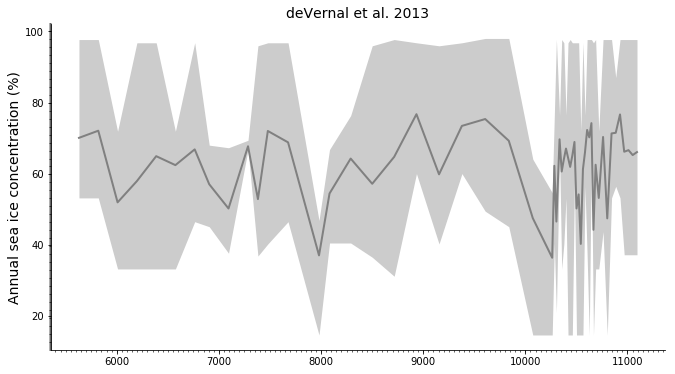

In [31]:
fig, ax_recon = plt.subplots(1, figsize=(11,6))

#plt.plot(halfar_time, halfar_sic)
plt.plot(deVernal_ds['Age [ka BP]']*1000, deVernal_ds['Sea ice conc [%] (annual)'], color='gray',linewidth=2)
plt.fill_between(deVernal_ds['Age [ka BP]']*1000, deVernal_ds['Sea ice conc [%] (annual, min)'], 
                 deVernal_ds['Sea ice conc [%] (annual, max)'],color='gray',alpha=0.4 ,lw=0.01)

#plt.ylim(1.5,-1.5)

ax_recon.spines['top'].set_visible(False)
ax_recon.spines['right'].set_visible(False)

plt.ylabel('Annual sea ice concentration (%)', fontsize=14)
plt.title('deVernal et al. 2013', fontsize=14)

ax_recon.yaxis.set_minor_locator(MultipleLocator(0.25))
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))

## Koseoglu et al. 2018 - Barents sea 

In [32]:
koseoglu_file = '/home/disk/chaos/mkb22/Documents/SeaIceData/si_proxy_records/Koseoglu_etal_2018/datasets/JM09-KA11-GC_HBI_biomarkers.tab'

koseoglu_ds = pd.read_csv(koseoglu_file,delimiter = "\t",skiprows=18)
koseoglu_ds.head()

Depth [m]  Age [ka BP]  IP25/sed [ng/g] (I)  HBIs/sed [ng/g] (II)  \
0      0.000        0.000                 1.46                  11.8   
1      0.005        0.053                 1.22                   5.6   
2      0.015        0.159                 1.42                   7.8   
3      0.033        0.317                 1.05                   6.6   
4      0.038        0.397                 1.70                   6.6   

   HBIs/sed [ng/g] (III)  HBIs/sed [ng/g] (IV)  P(III)IP25 (c=0.63)  \
0                   14.9                   7.8                 0.13   
1                    3.0                   1.6                 0.39   
2                    6.9                   3.3                 0.25   
3                    4.4                   2.1                 0.27   
4                    2.4                   1.2                 0.53   

   Sea ice conc [%] (Spring sea ice conc, PIP25-de...)  Sea ice type  
0                                                6.1        Marginal  
1                                               30.2    Intermediate  
2                                               16.5    Intermediate  
3                                               19.2    Intermediate  
4                                               43.0    Intermediate

In [33]:
koseoglu_ds.columns

Index(['Depth [m]', 'Age [ka BP]', 'IP25/sed [ng/g] (I)',
       'HBIs/sed [ng/g] (II)', 'HBIs/sed [ng/g] (III)', 'HBIs/sed [ng/g] (IV)',
       'P(III)IP25 (c=0.63)',
       'Sea ice conc [%] (Spring sea ice conc, PIP25-de...)', 'Sea ice type'],
      dtype='object')

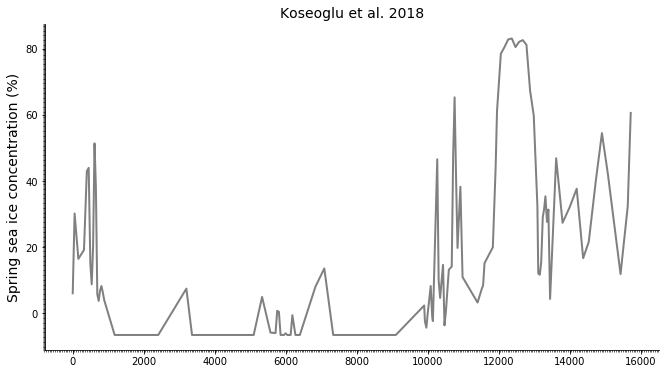

In [34]:
fig, ax_recon = plt.subplots(1, figsize=(11,6))

#plt.plot(halfar_time, halfar_sic)
plt.plot(koseoglu_ds['Age [ka BP]']*1000, 
         koseoglu_ds['Sea ice conc [%] (Spring sea ice conc, PIP25-de...)'], 
         color='gray',linewidth=2)


#plt.ylim(1.5,-1.5)

ax_recon.spines['top'].set_visible(False)
ax_recon.spines['right'].set_visible(False)

plt.ylabel('Spring sea ice concentration (%)', fontsize=14)
plt.title('Koseoglu et al. 2018', fontsize=14)

ax_recon.yaxis.set_minor_locator(MultipleLocator(0.25))
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))

## Porter et al. 2009 - Bering Sea

In [35]:
# Site_Information 
#       Site_Name: Bona-Churchill col
#       Location: North America>United States Of America>Alaska 
#       Country: United States Of America       
#       Northernmost_Latitude: 61.40
#       Southernmost_Latitude: 61.40
#       Easternmost_Longitude: -141.70 
#       Westernmost_Longitude: -141.70
#       Elevation: 4420 m

In [36]:
porter_file = 'Porter_etal_2019_AK_ice_core.csv'

porter_ds = pd.read_csv(data_dir+porter_file,delimiter = "\t",skiprows=100)
porter_ds.head()

age_CE   d18O  d18Osmooth
0    2001 -27.53         NaN
1    2000 -27.39         NaN
2    1999 -29.36         NaN
3    1998 -27.90         NaN
4    1997 -28.60         NaN

In [37]:
porter_ds.columns

Index(['age_CE', 'd18O', 'd18Osmooth'], dtype='object')

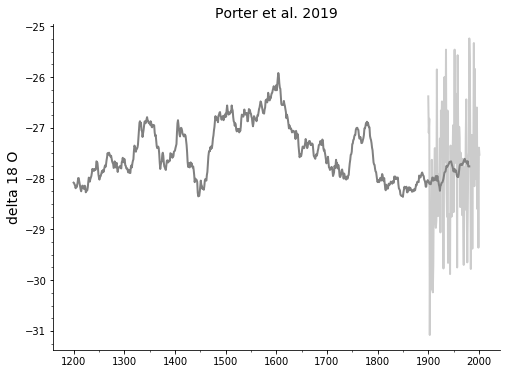

In [38]:
fig, ax_recon = plt.subplots(1, figsize=(8,6))

#plt.plot(halfar_time, halfar_sic)
plt.plot(porter_ds['age_CE'], porter_ds['d18O'], color='gray',linewidth=2, alpha=0.4)
plt.plot(porter_ds['age_CE'], porter_ds['d18Osmooth'], color='gray',linewidth=2)

#plt.ylim(1.5,-1.5)

ax_recon.spines['top'].set_visible(False)
ax_recon.spines['right'].set_visible(False)

plt.ylabel('delta 18 O', fontsize=14)
plt.title('Porter et al. 2019', fontsize=14)

ax_recon.yaxis.set_minor_locator(MultipleLocator(0.25))
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))

## Andrews et al. 2009 - North Atlantic/Iceland: 

In [39]:
andrews_file = 'Andrews_etal_2009_biomarkers.csv'

andrews_ds = pd.read_csv(data_dir+andrews_file,delimiter = "\s+",skiprows=207)
andrews_ds.head()

Depth    cm  IP25
0   0.00   NaN   NaN
1   0.25  0.27   NaN
2   0.50   NaN   NaN
3   0.75  0.40   NaN
4   1.00   NaN   NaN

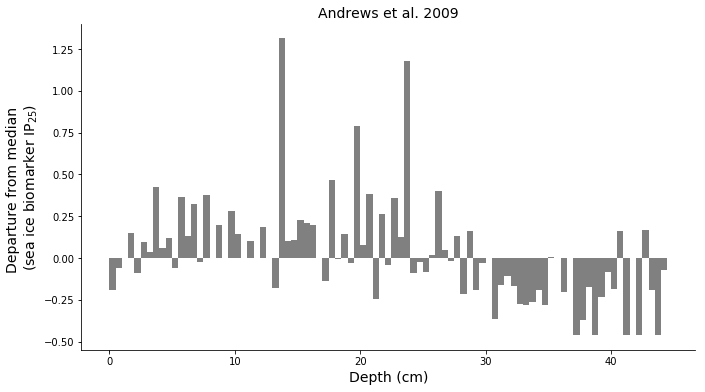

In [40]:
fig, ax_recon = plt.subplots(1, figsize=(11,6))

#plt.plot(halfar_time, halfar_sic)
plt.bar(andrews_ds['Depth'], andrews_ds['cm']-0.46, color='gray',width=0.5)
#plt.plot(andrews_ds['Depth'], andrews_ds['cm'], color='gray',linewidth=2)

#plt.ylim(1.5,-1.5)

ax_recon.spines['top'].set_visible(False)
ax_recon.spines['right'].set_visible(False)

plt.ylabel('Departure from median \n(sea ice biomarker IP$_{25}$)', fontsize=14)
plt.xlabel('Depth (cm)', fontsize=14)

plt.title('Andrews et al. 2009', fontsize=14)

ax_recon.yaxis.set_minor_locator(MultipleLocator(0.25))
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))


# Kinnard Data: 

In [69]:
# Column number
# 1- Year AD
# 2-40 year lowpass reconstructed August Arctic sea-ice extent in km^2 (this study)
# 3-Reconstructed sea ice extent lower 95% confidence interval in km^2 (this study)
# 4-Reconstructed sea ice extent upper 95% confidence interval in km^2 (this study)
# 5-40 year lowpass observed sea ice extent  in 10^6 km^2 (this study)
# 6-Dinocysts-based reconstruction of Fram Strait sea ice in month per yr with > 50% ice concentration (Bonnet et al, 2010))
# 7-Observed Fram Strait ice cover in month per yr with > 50% ice concentration (from Walsh and Chapman, 2001))
# 8-Dinocysts-based reconstruction of Chukchi Sea ice cover in months per yr with >50% ice concentration (deVernal et al, 2008)
# 9- Observed Chukchi ice cover in months per yr with >50% ice concentration (from Walsh and Chapman, 2001)
# 10-IP25-based reconstruction of Barents Sea ice occurence (Vare et al, 2010)
# 11-IP25-based reconstruction of Northern Iceland sea ice occurence (Massé et al, 2008)
# 12-Reconstructed Arctic Temperature (Kaufman et al, 2009) 
# 13-CRUTEM3 Arctic temperature anomalies (Brohan et al, 2006) 
# 14-Reconstructed NAO index (Trouet et al, 2009)
# 15-Reconstructed NAO index, scaled to Trouet09 record (Cook et al, 2002)
# 16-Reconstructed Fram Strait Salinity anomalies(Bonnet et al, 2010)
# 17-Reconstructed Fram Strait sea surface temperature anomalies (Bonnet et al, 2010)

In [70]:
kinnard_file = 'Kinnard_etal_2011_figure3.xls'

In [71]:
kinnard_df = pd.read_excel(io=data_dir+kinnard_file, skiprows=26)

In [73]:
kinnard_years = kinnard_df[1].values
kinnard_recon = kinnard_df[2].values/1e6
kinnard_recon_low = kinnard_df[3].values/1e6
kinnard_recon_high = kinnard_df[4].values/1e6

Bonnet_2010 = kinnard_df[6].values
Walsh_2001 = kinnard_df[7].values

Vare_2010 = kinnard_df[10].values
Vare_lat = 77 + 58.97/60
Vare_lon = (26 + 47.61/60)

Masse_2008 = kinnard_df[11].values
Masse_lat = 66 + 33.06/60
Masse_lon = 360 -(17 + 41.59/60)

deVernal_2008 = kinnard_df[8].values
deVernal_lat = 74.51
deVernal_lon = 360 - 159.9766667

Walsh_fram_2001 = kinnard_df[6]

In [74]:
Wn2 = 1.0/40
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)

recon_sic_filt40 = signal.filtfilt(b2,a2,sie_ensmn_anom_allit_ccsm4)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [75]:
[ce_kinnard_ccsm4,
 corr_kinnard_ccsm4,_,_] = rrutils.find_ce_corr(kinnard_recon, 
                                                recon_sic_filt40,
                                                np.array(recon_years),
                                                kinnard_years,563,1995)

In [76]:
corr_kinnard_ccsm4**2

0.0512873315883013

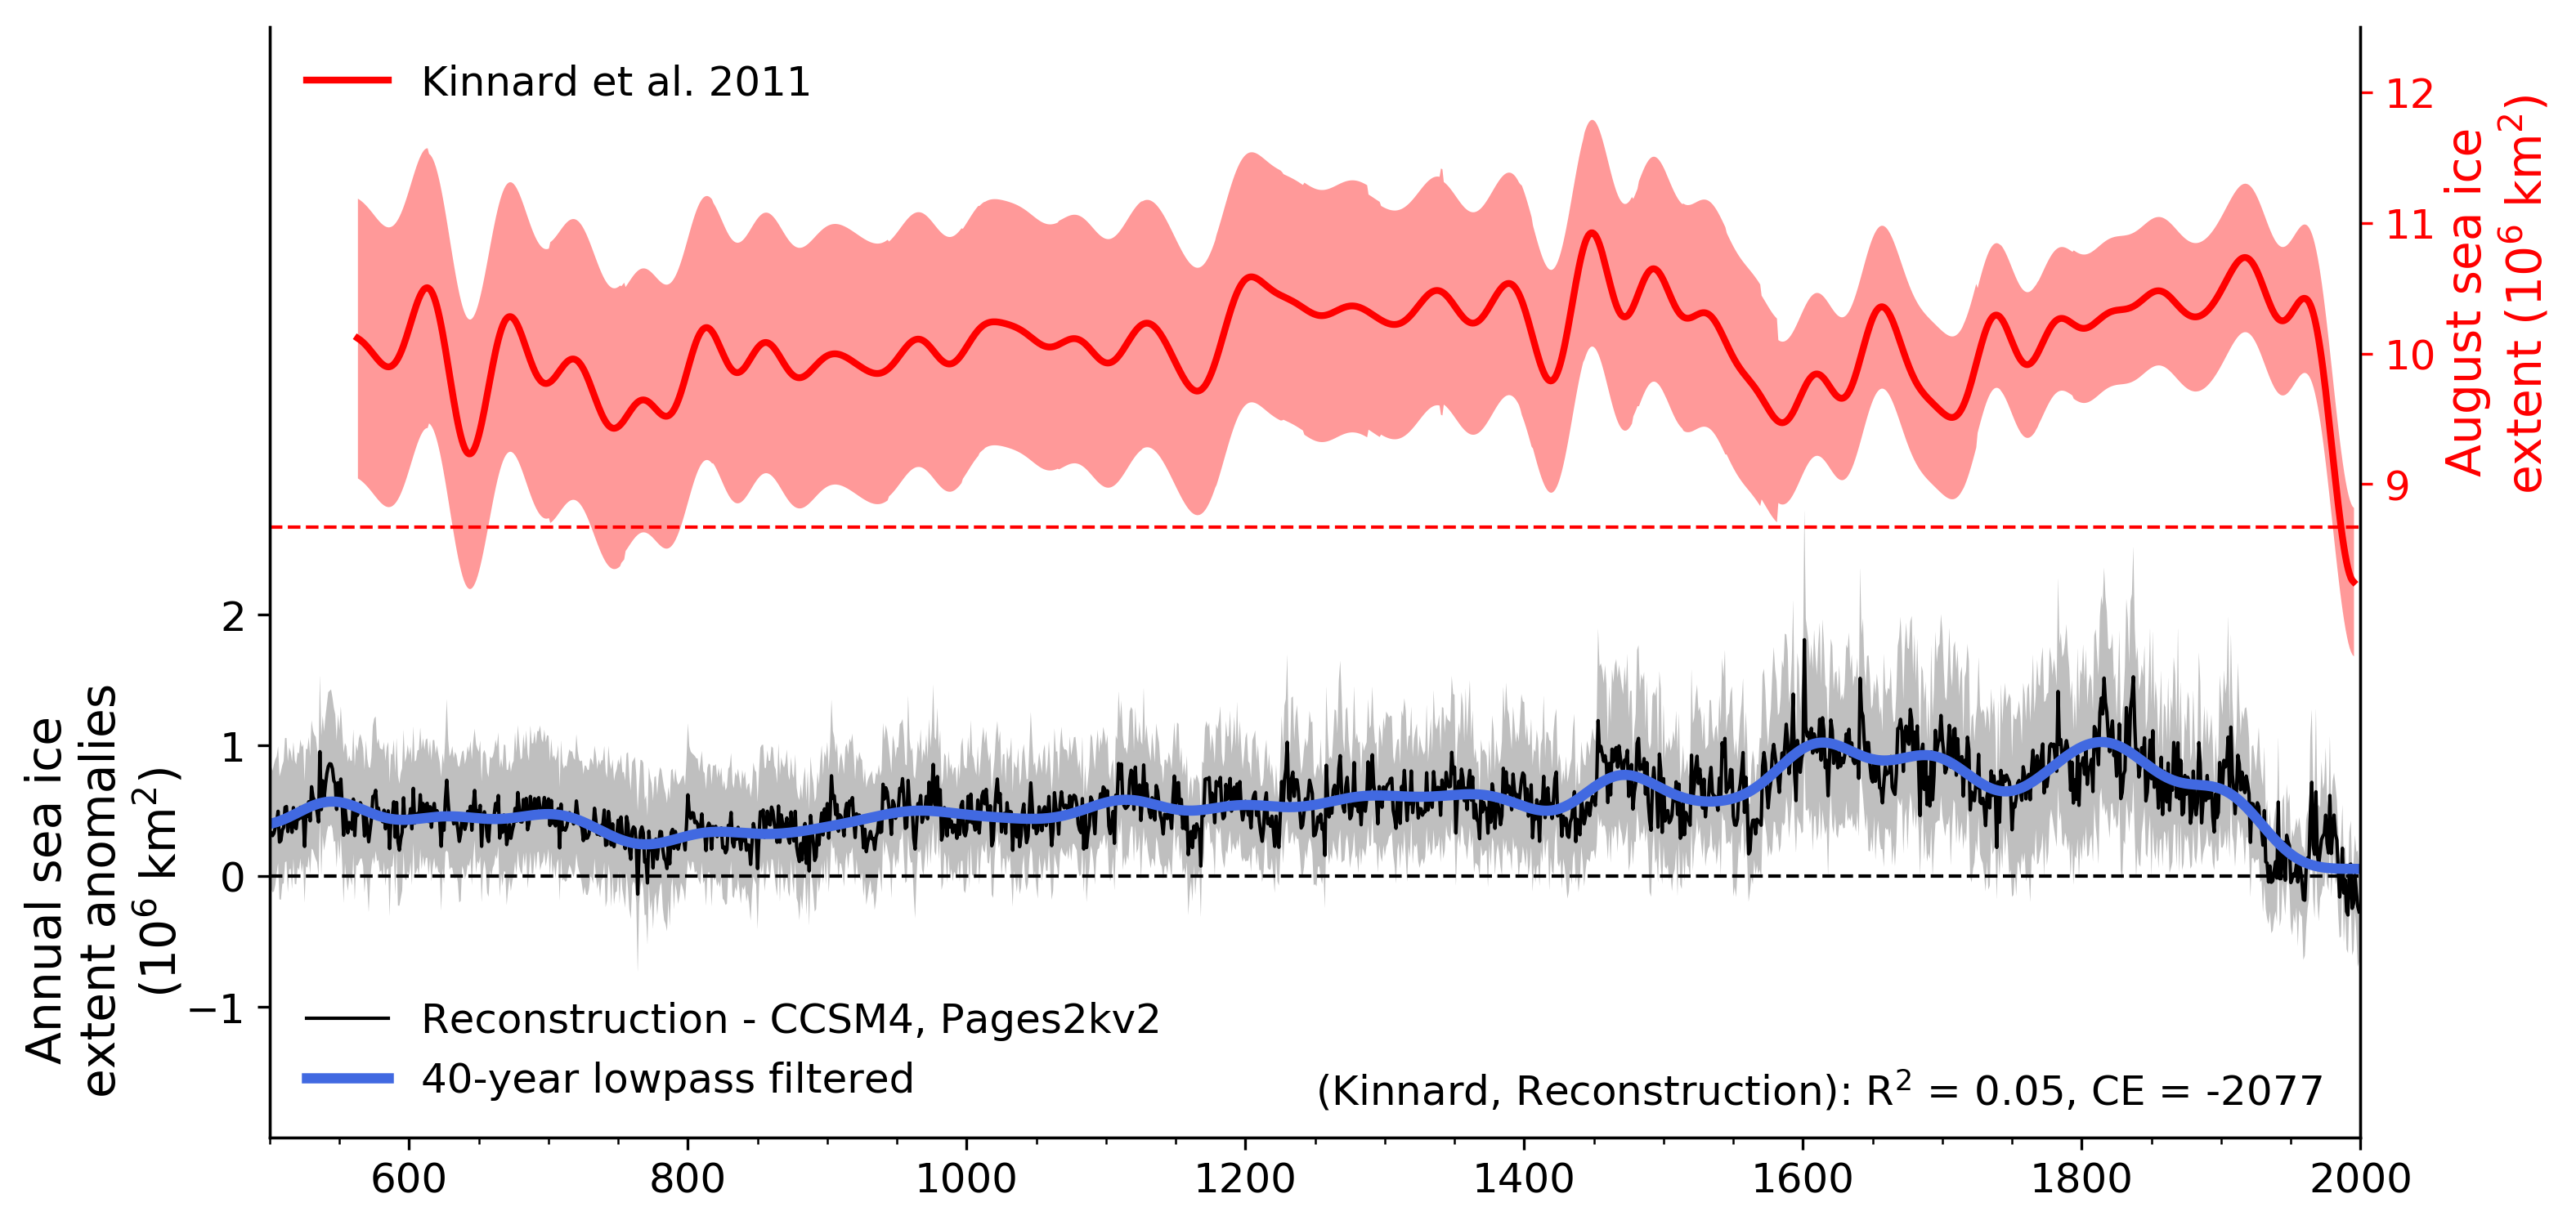

In [80]:
kinnard_sat_mean = np.nanmean(kinnard_recon[np.where((kinnard_years>=1979)&(kinnard_years<=2000))])

fig, ax_recon = plt.subplots(1, figsize=(11,6))

ax_recon.axhline(0,linestyle='--',color='k', linewidth=1)

ax_recon.fill_between(recon_years,sie_2_5_allit_ccsm4,sie_97_5_allit_ccsm4,
                      color='gray',lw=0.01,alpha=0.5)
ax_recon.plot(recon_years,sie_ensmn_anom_allit_ccsm4,color='k',
         label='Reconstruction - CCSM4, Pages2kv2',linewidth=1)
ax_recon.plot(recon_years,recon_sic_filt40,color='royalblue',
         label='40-year lowpass filtered',linewidth=3)

ax_proxy = ax_recon.twinx()
ax_proxy.axhline(kinnard_sat_mean,linestyle='--',color='r', linewidth=1)
ax_proxy.plot(kinnard_years,kinnard_recon,color='r', linewidth=2, label='Kinnard et al. 2011')
ax_proxy.fill_between(kinnard_years,kinnard_recon_low,kinnard_recon_high, alpha=0.4, color='r',lw=0.01)

#plt.ylim(1.5,-1.5)

ax_proxy.set_ylim(4,12.5)
ax_recon.set_ylim(-2,6.5)
ax_proxy.set_xlim(500,2000)
ax_recon.set_xlim(500,2000)

ax_recon.spines['top'].set_visible(False)
ax_proxy.spines['top'].set_visible(False)

ax_recon.set_yticks(np.arange(-1,3,1))
ax_proxy.set_yticks(np.arange(9,13,1))

ax_proxy.set_ylabel('August sea ice \nextent (10$^6$ km$^2$)', fontsize=14)
ax_recon.set_ylabel('Annual sea ice \nextent anomalies \n(10$^6$ km$^2$)', fontsize=14)
#plt.title('Barents Sea: Regional Comparison', fontsize=16)

ax_proxy.yaxis.set_label_coords(1.04, 0.76)
ax_recon.yaxis.set_label_coords(-0.04, 0.23)

ax_proxy.legend(loc='upper left',frameon=False, fontsize=12)
ax_recon.legend(loc='lower left',frameon=False, fontsize=12)
#ax_recon.legend(bbox_to_anchor=[0.0,0.54],frameon=False, fontsize=14)

#ax_proxy.yaxis.set_minor_locator(MultipleLocator(0.1))
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))

ax_proxy.yaxis.label.set_color('r')
ax_proxy.tick_params(axis='y', colors='r')

ax_recon.text(1250,-1.75,('(Kinnard, Reconstruction): R$^2$ = '+str(np.round(corr_kinnard_ccsm4**2,2))+
                         ', CE = '+str(int(ce_kinnard_ccsm4))),fontsize=12)

ax_recon.tick_params(axis='both', which='major', labelsize=12)
ax_proxy.tick_params(axis='both', which='major', labelsize=12)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Kinnard_comparison_ccsm4.png'
plt.savefig(savedir+savename)

In [44]:
filled = kinnard_df[6].fillna(limit=2, method='ffill')


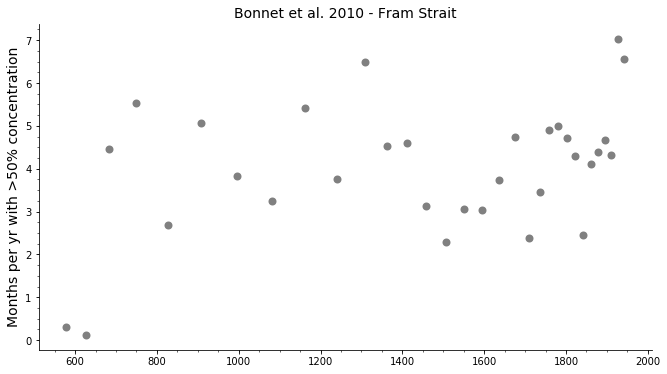

In [45]:
fig, ax_recon = plt.subplots(1, figsize=(11,6))

#ax_proxy = ax_recon.twinx()

#plt.plot(halfar_time, halfar_sic)
plt.scatter(kinnard_years, Bonnet_2010, color='gray',linewidth=2)#,ax = ax_proxy)

#plt.ylim(1.5,-1.5)

ax_recon.spines['top'].set_visible(False)
ax_recon.spines['right'].set_visible(False)

plt.ylabel('Months per yr with >50% concentration', fontsize=14)
plt.title('Bonnet et al. 2010 - Fram Strait', fontsize=14)

ax_recon.yaxis.set_minor_locator(MultipleLocator(0.25))
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))

## Chukchi Sea Comparison - deVernal et al 2008 

In [46]:
diff_lat = ccsm4_truth_lat[:,0] - deVernal_lat
diff_lon = ccsm4_truth_lon[0,:] - deVernal_lon

lat_closest = np.where(np.isclose(np.abs(diff_lat),np.min(np.abs(diff_lat))))[0][0]
lon_closest = np.where(np.isclose(np.abs(diff_lon),np.min(np.abs(diff_lon))))[0][0]

min_yr = kinnard_years.min()

recon_deVernal_comparison = np.nanmean(sic_lalo_allit_ccsm4[min_yr:,lat_closest,lon_closest,:],axis=1)

In [47]:
Wn2 = 1.0/20
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)

ccsm4_devernal_filt20 = signal.filtfilt(b2,a2,recon_deVernal_comparison)
chukchi_sie_filt20 = signal.filtfilt(b2,a2,chukchi_sie_anom)
chukchi_sic_filt20 = signal.filtfilt(b2,a2,chukchi_sic_anom)
chukchi_walsh_filt20 = signal.filtfilt(b2,a2,walsh_chukchi_sia)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


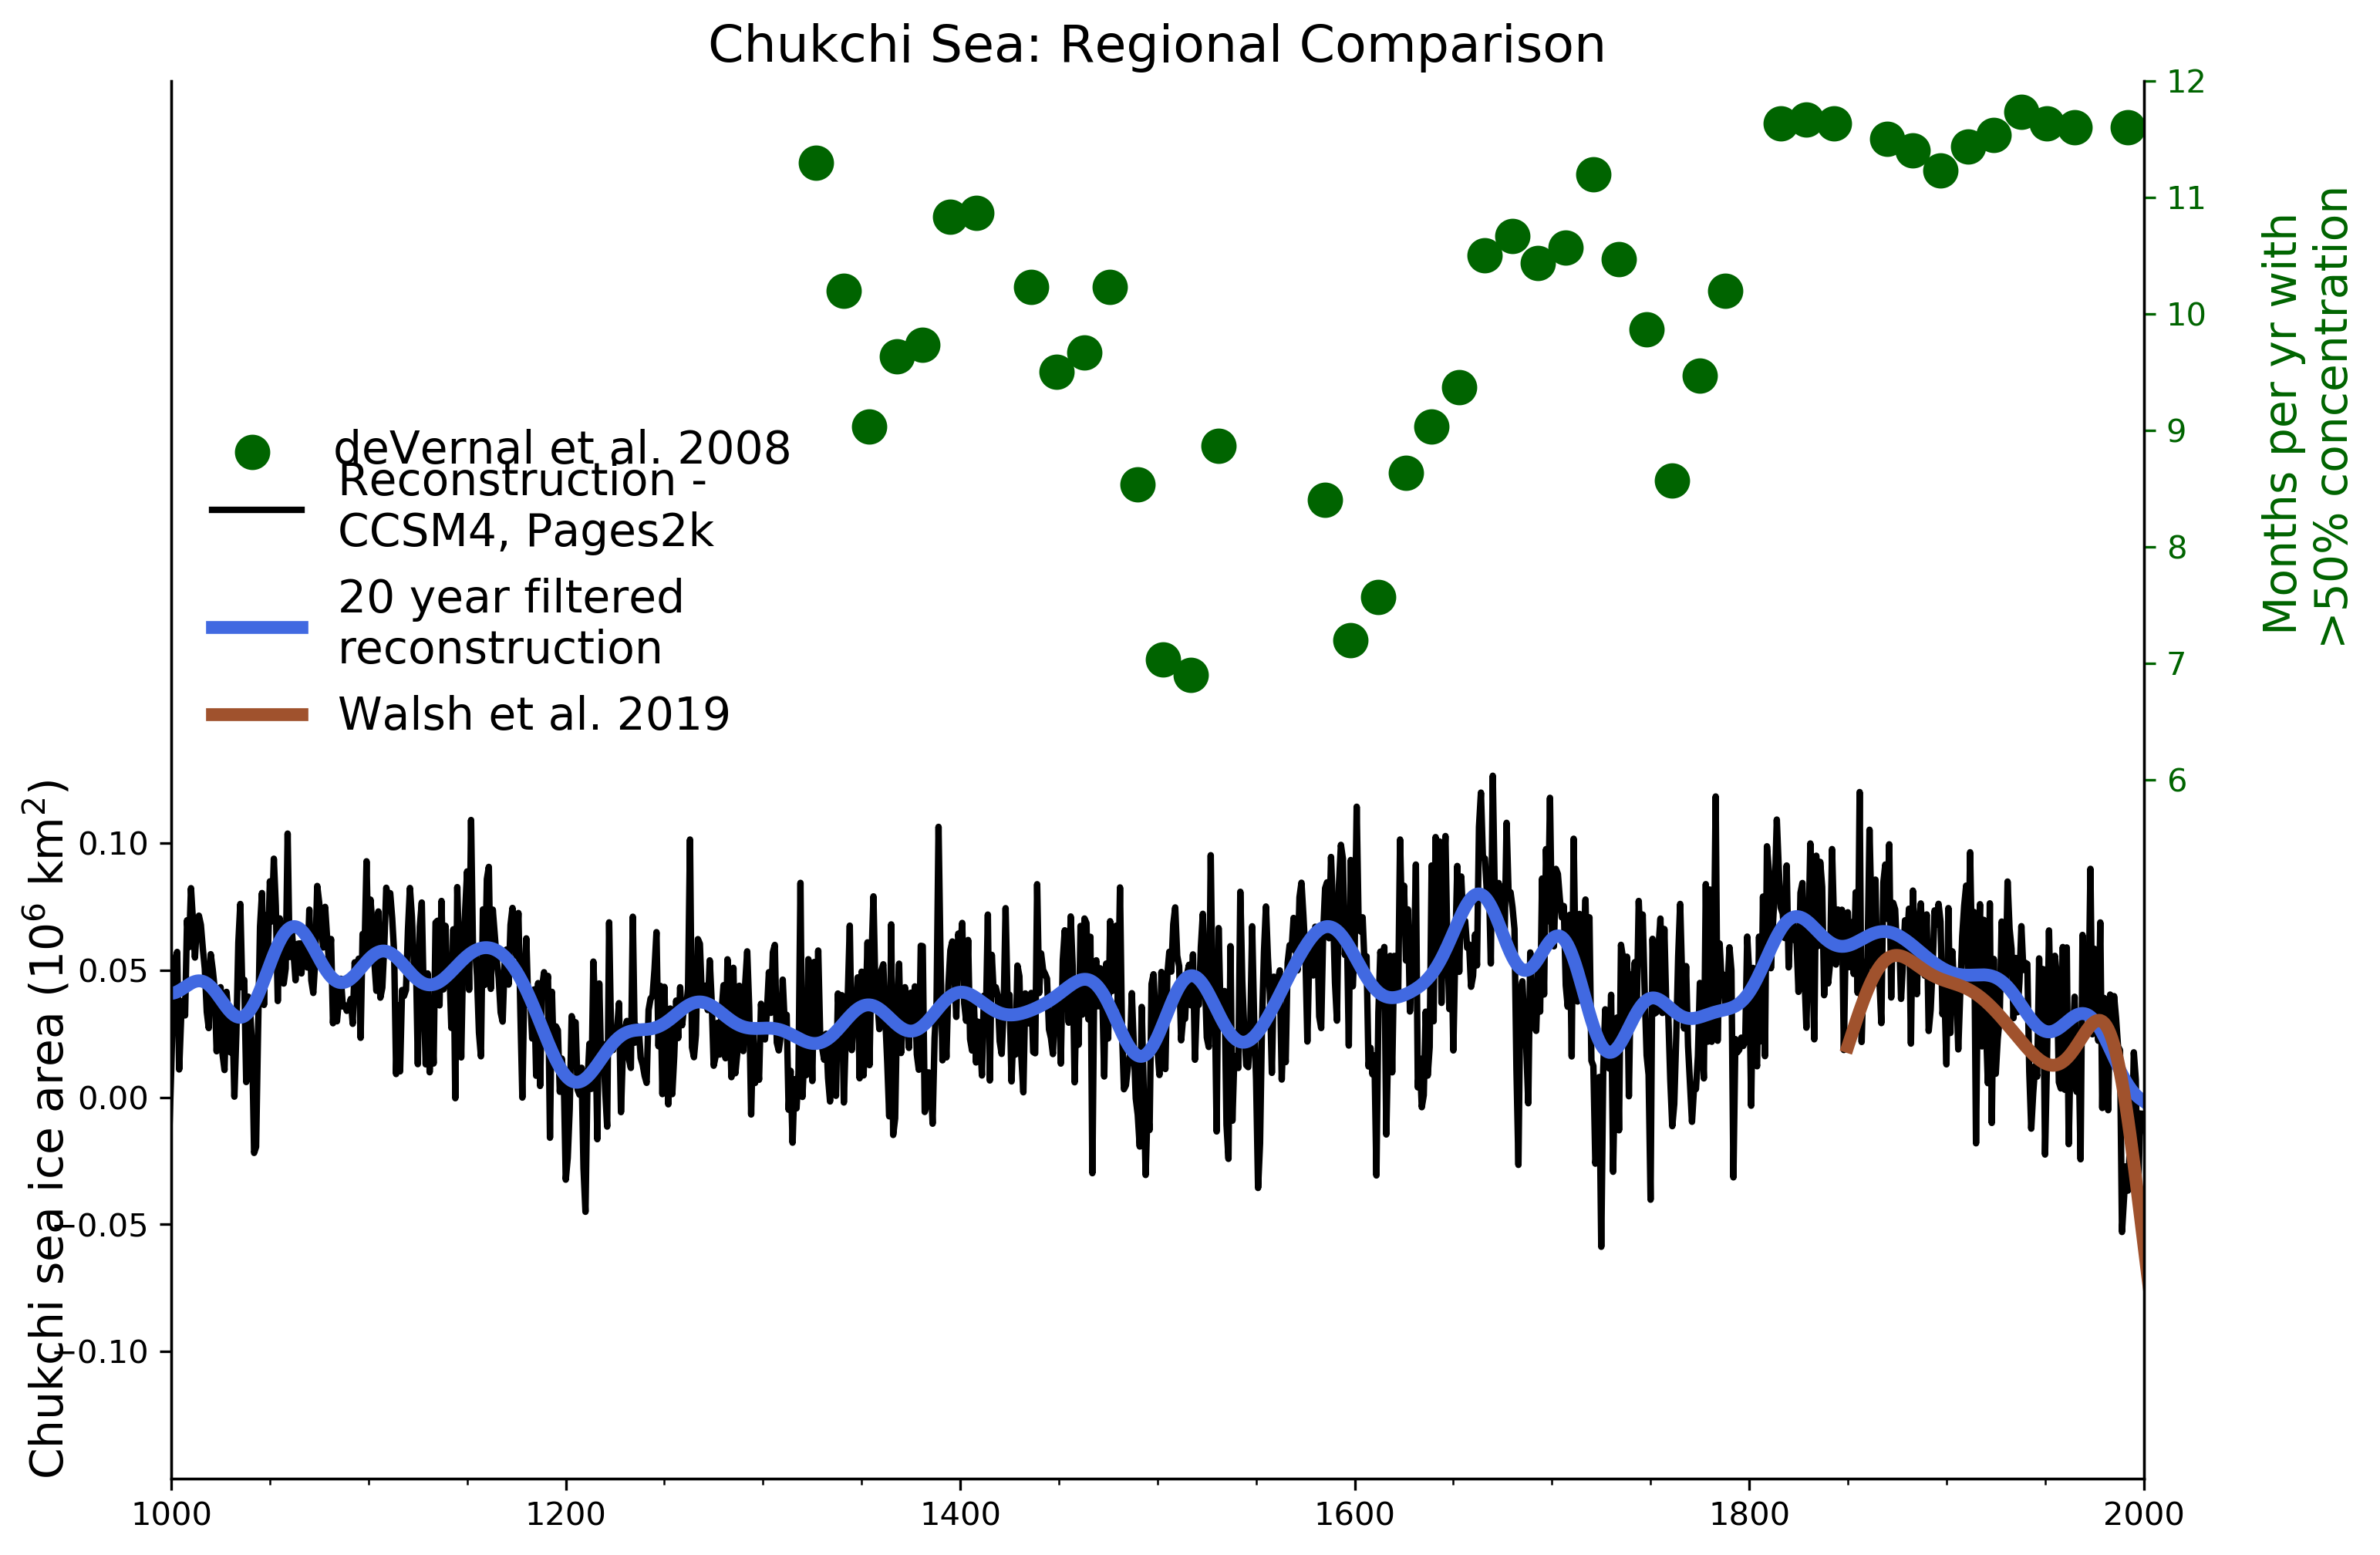

In [48]:
fig, ax_recon = plt.subplots(1, figsize=(11,8))

plt.plot(np.flip(kinnard_years[9:]), chukchi_sic_anom[min_yr:], color='k',linewidth=2,
         label='Reconstruction - \nCCSM4, Pages2k')
plt.plot(np.flip(kinnard_years[9:]), chukchi_sic_filt20[min_yr:], color='royalblue',linewidth=4,
         label='20 year filtered \nreconstruction')
# plt.fill_between(np.flip(kinnard_years[9:]),chukchi_sic_lowanom[min_yr:],
#                  chukchi_sic_highanom[min_yr:],color='gray',alpha=0.5, edgecolor=None)

plt.plot(walsh_time, chukchi_walsh_filt20, color='sienna',linewidth=4,
         label='Walsh et al. 2019')

ax_proxy = ax_recon.twinx()
plt.scatter(kinnard_years[9:], deVernal_2008[9:], color='darkgreen',linewidth=5, label='deVernal et al. 2008')

#plt.ylim(1.5,-1.5)

ax_proxy.set_ylim(0,12)
ax_recon.set_ylim(-0.15,0.4)
ax_proxy.set_xlim(1000,2000)
ax_recon.set_xlim(1000,2000)

ax_recon.spines['top'].set_visible(False)
ax_proxy.spines['top'].set_visible(False)

ax_recon.set_yticks(np.arange(-0.1,0.15,0.05))
ax_proxy.set_yticks(np.arange(6,12.1,1))

ax_proxy.set_ylabel('Months per yr with \n>50% concentration', fontsize=14)
ax_recon.set_ylabel('Chukchi sea ice area (10$^6$ km$^2$)', fontsize=14)
plt.title('Chukchi Sea: Regional Comparison', fontsize=16)

ax_proxy.yaxis.set_label_coords(1.06, 0.76)
ax_recon.yaxis.set_label_coords(-0.05, 0.25)

ax_proxy.yaxis.label.set_color('darkgreen')
ax_proxy.tick_params(axis='y', colors='darkgreen')

ax_proxy.legend(bbox_to_anchor=[0.335,0.78],frameon=False, fontsize=14)
ax_recon.legend(bbox_to_anchor=[0.0,0.5],frameon=False, fontsize=14)

#ax_recon.yaxis.set_minor_locator(MultipleLocator(2.5))
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))

In [49]:
[ce_chukchi_walsh_ccsm4,
 corr_chukchi_walsh_ccsm4,_,_] = rrutils.find_ce_corr(walsh_chukchi_sia, 
                                                     chukchi_sic_anom,
                                                     np.array(recon_years),
                                                     walsh_time,1850,1999)

In [50]:
ce_chukchi_walsh_ccsm4,corr_hukchi_walsh_ccsm4**2

NameError: name 'corr_hukchi_walsh_ccsm4' is not defined

(array([-0.1 , -0.05,  0.  ,  0.05,  0.1 ]),
 <a list of 5 Text yticklabel objects>)

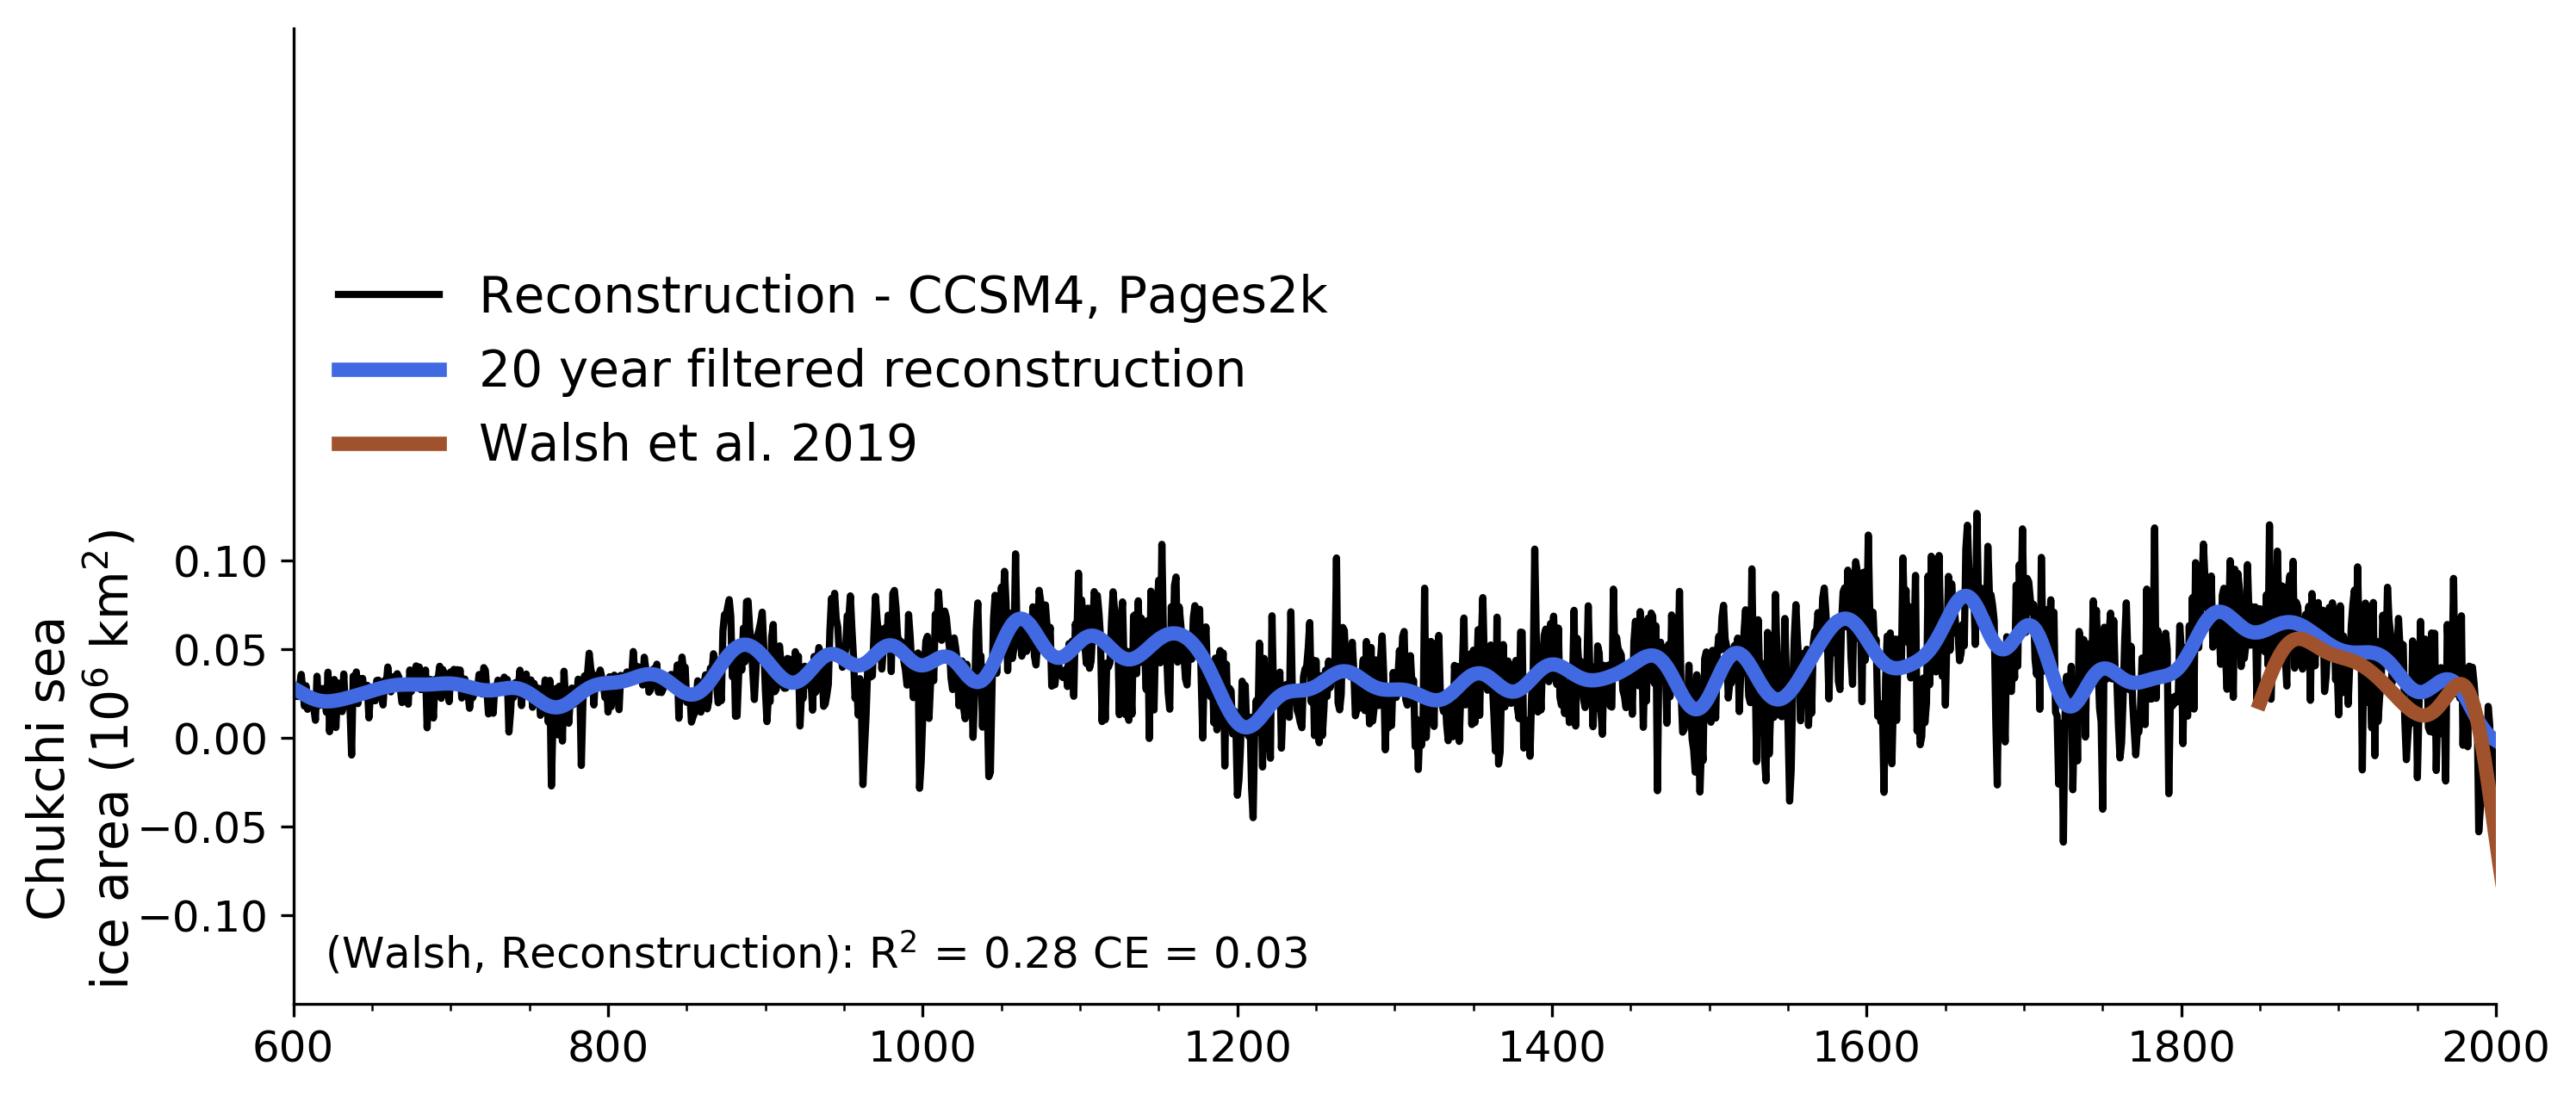

In [52]:
fig, ax_recon = plt.subplots(1, figsize=(11,5))

plt.plot(np.array(recon_years), chukchi_sic_anom, color='k',linewidth=2,
         label='Reconstruction - CCSM4, Pages2k')
plt.plot(np.array(recon_years), chukchi_sic_filt20, color='royalblue',linewidth=4,
         label='20 year filtered reconstruction')
# plt.fill_between(np.flip(kinnard_years[9:]),chukchi_sic_lowanom[min_yr:],
#                  chukchi_sic_highanom[min_yr:],color='gray',alpha=0.5, edgecolor=None)

plt.plot(walsh_time, chukchi_walsh_filt20, color='sienna',linewidth=4,
         label='Walsh et al. 2019')
#plt.plot(walsh_time, walsh_chukchi_sia, color='sienna',linewidth=2)

# ax_proxy = ax_recon.twinx()
# plt.scatter(kinnard_years[9:], deVernal_2008[9:], color='darkgreen',linewidth=5, label='deVernal et al. 2008')

#plt.ylim(1.5,-1.5)


ax_recon.set_ylim(-0.15,0.4)
ax_recon.set_xlim(600,2000)

ax_recon.spines['top'].set_visible(False)
ax_recon.spines['right'].set_visible(False)

ax_recon.set_yticks(np.arange(-0.1,0.15,0.05))

ax_recon.set_ylabel('Chukchi sea \nice area (10$^6$ km$^2$)', fontsize=14)
#plt.title('Chukchi Sea: Regional Comparison', fontsize=16)

ax_recon.yaxis.set_label_coords(-0.07, 0.25)
ax_recon.legend(bbox_to_anchor=[0.0,0.5],frameon=False, fontsize=14)
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))

ax_recon.text(620,-0.13,('(Walsh, Reconstruction): R$^2$ = '+str(np.round(corr_chukchi_walsh_ccsm4**2,2))+
                         ' CE = '+str(np.round(ce_chukchi_walsh_ccsm4,2))),fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

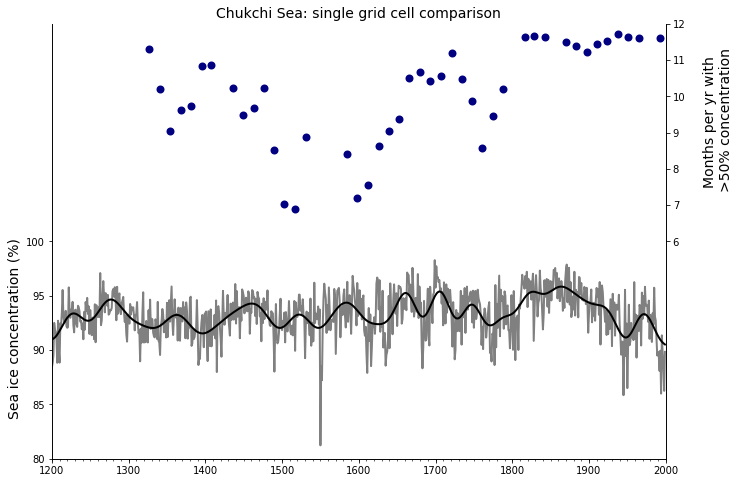

In [51]:
fig, ax_recon = plt.subplots(1, figsize=(11,8))

plt.plot(np.flip(kinnard_years[9:]), recon_deVernal_comparison, color='gray',linewidth=2)
plt.plot(np.flip(kinnard_years[9:]), ccsm4_devernal_filt20, color='k',linewidth=2)


ax_proxy = ax_recon.twinx()
plt.scatter(kinnard_years[9:], deVernal_2008[9:], color='navy',linewidth=2)

#plt.ylim(1.5,-1.5)

ax_proxy.set_ylim(0,12)
ax_recon.set_ylim(80,120)
ax_proxy.set_xlim(1200,2000)
ax_recon.set_xlim(1200,2000)

ax_recon.spines['top'].set_visible(False)
ax_proxy.spines['top'].set_visible(False)

ax_recon.set_yticks(np.arange(80,101,5))
ax_proxy.set_yticks(np.arange(6,12.1,1))

ax_proxy.set_ylabel('Months per yr with \n>50% concentration', fontsize=14)
ax_recon.set_ylabel('Sea ice concentration (%)', fontsize=14)
plt.title('Chukchi Sea: single grid cell comparison', fontsize=14)

ax_proxy.yaxis.set_label_coords(1.06, 0.78)
ax_recon.yaxis.set_label_coords(-0.05, 0.3)

#ax_recon.yaxis.set_minor_locator(MultipleLocator(2.5))
ax_recon.xaxis.set_minor_locator(MultipleLocator(10))

## Barents Sea Comparison: Vare et al 2010 

In [81]:
# Closest gridpoint 

diff_lat = ccsm4_truth_lat[:,0] - Vare_lat
diff_lon = ccsm4_truth_lon[0,:] - Vare_lon

lat_closest = np.where(np.isclose(np.abs(diff_lat),np.min(np.abs(diff_lat))))[0][0]
lon_closest = np.where(np.isclose(np.abs(diff_lon),np.min(np.abs(diff_lon))))[0][0]

min_yr = kinnard_years.min()

recon_Vare_comparison = np.nanmean(sic_lalo_allit_ccsm4[min_yr:,lat_closest,lon_closest,:],axis=1)

In [82]:
[ce_barents_walsh_ccsm4,
 corr_barents_walsh_ccsm4,_,_] = rrutils.find_ce_corr(walsh_regional_sia['Barents Sea'], 
                                                     regional_sic_anom['Barents Sea'],
                                                     np.array(recon_years),
                                                     walsh_time,1850,1999)

In [83]:
Wn2 = 1.0/15
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)

ccsm4_Vare_filt20 = signal.filtfilt(b2,a2,recon_Vare_comparison)
barents_sie_filt20 = signal.filtfilt(b2,a2,regional_sie_anom['Barents Sea'])
barents_sic_filt20 = signal.filtfilt(b2,a2,regional_sic_anom['Barents Sea'])
barents_walsh_filt20 = signal.filtfilt(b2,a2,walsh_regional_sia['Barents Sea'])

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


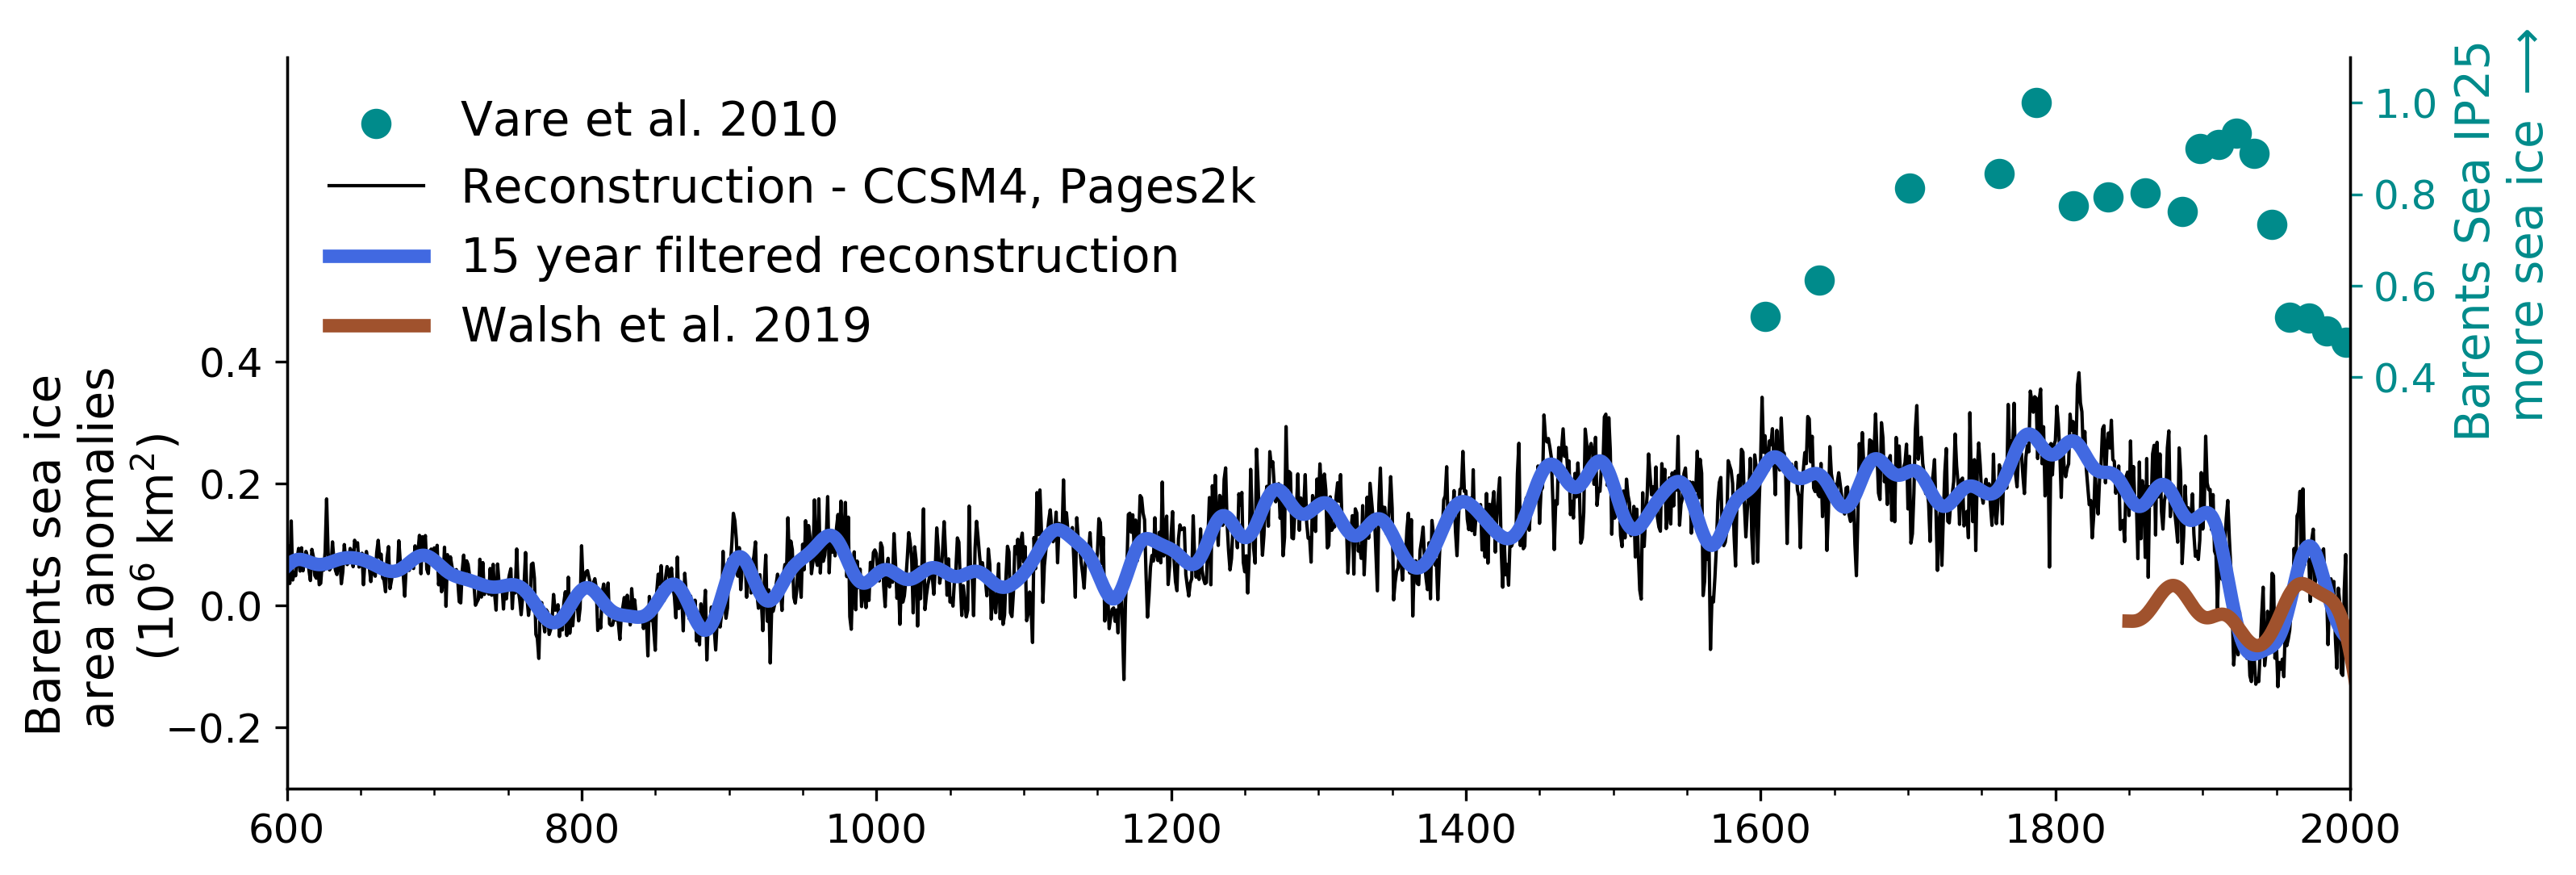

In [116]:
fig, ax_recon = plt.subplots(1, figsize=(11,4))

plt.plot(np.flip(kinnard_years[9:]), regional_sic_anom['Barents Sea'][min_yr:], color='k',linewidth=1,
         label='Reconstruction - CCSM4, Pages2k')
plt.plot(np.flip(kinnard_years[9:]), barents_sic_filt20[min_yr:], color='royalblue',linewidth=4,
         label='15 year filtered reconstruction')
# plt.fill_between(np.flip(kinnard_years[9:]),barents_sic_lowanom[min_yr:],
#                  barents_sic_highanom[min_yr:],color='gray',alpha=0.5, edgecolor=None)

plt.plot(walsh_time, barents_walsh_filt20, color='sienna',linewidth=4,
         label='Walsh et al. 2019')

ax_proxy = ax_recon.twinx()
plt.scatter(kinnard_years[9:], Vare_2010[9:], color='darkcyan',linewidth=3, label='Vare et al. 2010')

#plt.ylim(1.5,-1.5)

ax_proxy.set_ylim(-0.5,1.1)
ax_recon.set_ylim(-0.3,0.9)
ax_proxy.set_xlim(600,2000)
ax_recon.set_xlim(600,2000)

ax_recon.spines['top'].set_visible(False)
ax_proxy.spines['top'].set_visible(False)

ax_recon.set_yticks(np.arange(-0.2,0.4,0.2))
ax_proxy.set_yticks(np.arange(0.4,1.1,0.2))

ax_proxy.set_ylabel('Barents Sea IP25 \n more sea ice $\longrightarrow$', fontsize=14)
ax_recon.set_ylabel('Barents sea ice \narea anomalies\n(10$^6$ km$^2$)', fontsize=14)
#plt.title('Barents Sea: Regional Comparison', fontsize=16)

ax_proxy.yaxis.set_label_coords(1.05, 0.76)
ax_recon.yaxis.set_label_coords(-0.05, 0.33)

ax_proxy.legend(loc='upper left',frameon=False, fontsize=14)
ax_recon.legend(bbox_to_anchor=[0.0,0.54],frameon=False, fontsize=14)

#ax_proxy.yaxis.set_minor_locator(MultipleLocator(0.1))
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))

ax_proxy.yaxis.label.set_color('darkcyan')
ax_proxy.tick_params(axis='y', colors='darkcyan')

# ax_recon.text(620,-0.25,('(Walsh, Reconstruction): R$^2$ = '+str(np.round(corr_barents_walsh_ccsm4**2,2))+
#                          ' CE = '+str(np.round(ce_barents_walsh_ccsm4,2))),fontsize=12)

ax_recon.tick_params(axis='both', which='major', labelsize=12)
ax_proxy.tick_params(axis='both', which='major', labelsize=12)

# ax_recon.axvline(1940)
# ax_recon.axvline(1920)

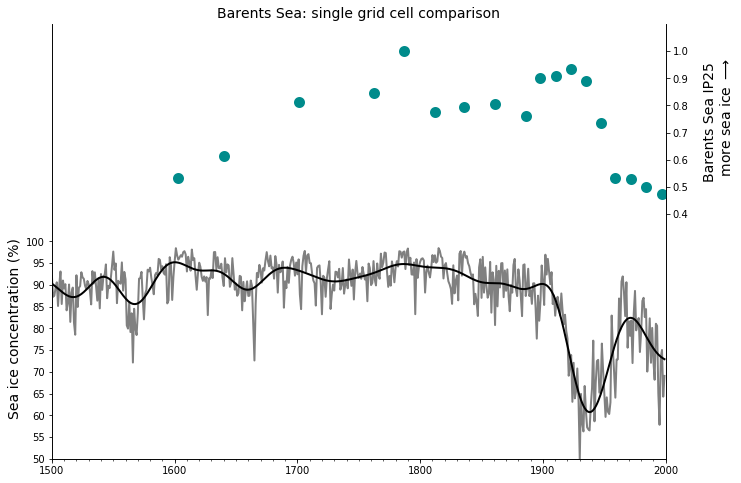

In [97]:
fig, ax_recon = plt.subplots(1, figsize=(11,8))

plt.plot(np.flip(kinnard_years[9:]), recon_Vare_comparison, color='gray',linewidth=2)
plt.plot(np.flip(kinnard_years[9:]), ccsm4_Vare_filt20, color='k',linewidth=2)


ax_proxy = ax_recon.twinx()
plt.scatter(kinnard_years[9:], Vare_2010[9:], color='darkcyan',linewidth=5)

#plt.ylim(1.5,-1.5)

ax_proxy.set_ylim(-0.5,1.1)
ax_recon.set_ylim(50,150)
ax_proxy.set_xlim(1500,2000)
ax_recon.set_xlim(1500,2000)

ax_recon.spines['top'].set_visible(False)
ax_proxy.spines['top'].set_visible(False)

ax_recon.set_yticks(np.arange(50,101,5))
ax_proxy.set_yticks(np.arange(0.4,1.01,0.1))

ax_proxy.set_ylabel('Barents Sea IP25 \n more sea ice $\longrightarrow$', fontsize=14)
ax_recon.set_ylabel('Sea ice concentration (%)', fontsize=14)
plt.title('Barents Sea: single grid cell comparison', fontsize=14)

ax_proxy.yaxis.set_label_coords(1.06, 0.78)
ax_recon.yaxis.set_label_coords(-0.05, 0.3)

#ax_recon.yaxis.set_minor_locator(MultipleLocator(2.5))
ax_recon.xaxis.set_minor_locator(MultipleLocator(10))

## Northern Iceland Comparison: Masse et al. 2008 

In [87]:
diff_lat = ccsm4_truth_lat[:,0] - Masse_lat
diff_lon = ccsm4_truth_lon[0,:] - Masse_lon

lat_closest = np.where(np.isclose(np.abs(diff_lat),np.min(np.abs(diff_lat))))[0][0]
lon_closest = np.where(np.isclose(np.abs(diff_lon),np.min(np.abs(diff_lon))))[0][0]

min_yr = kinnard_years.min()
# min_yr = 650

recon_Masse_comparison = sic_lalo_allit_ccsm4[min_yr:,lat_closest,lon_closest,:]

recon_Masse_enmn = np.nanmean(recon_Masse_comparison,axis=1)
recon_Masse_low = np.percentile(recon_Masse_comparison,2.5,axis=1)
recon_Masse_high = np.percentile(recon_Masse_comparison,97.5,axis=1)

In [88]:
Masse_lat,Masse_lon, ccsm4_truth_lat[:,0][lat_closest], ccsm4_truth_lon[0,:][lon_closest]

(66.551, 342.3068333333333, 67.25274725274726, 342.0)

In [99]:
Wn2 = 1.0/15
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)

ccsm4_Masse_filt20 = signal.filtfilt(b2,a2,recon_Masse_enmn)
fram_sic_filt20 = signal.filtfilt(b2,a2,regional_sic_anom['East Greenland Sea'])
fram_sie_filt20 = signal.filtfilt(b2,a2,regional_sie_anom['East Greenland Sea'])
fram_walsh_filt20= signal.filtfilt(b2,a2,walsh_regional_sia['East Greenland Sea'])

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


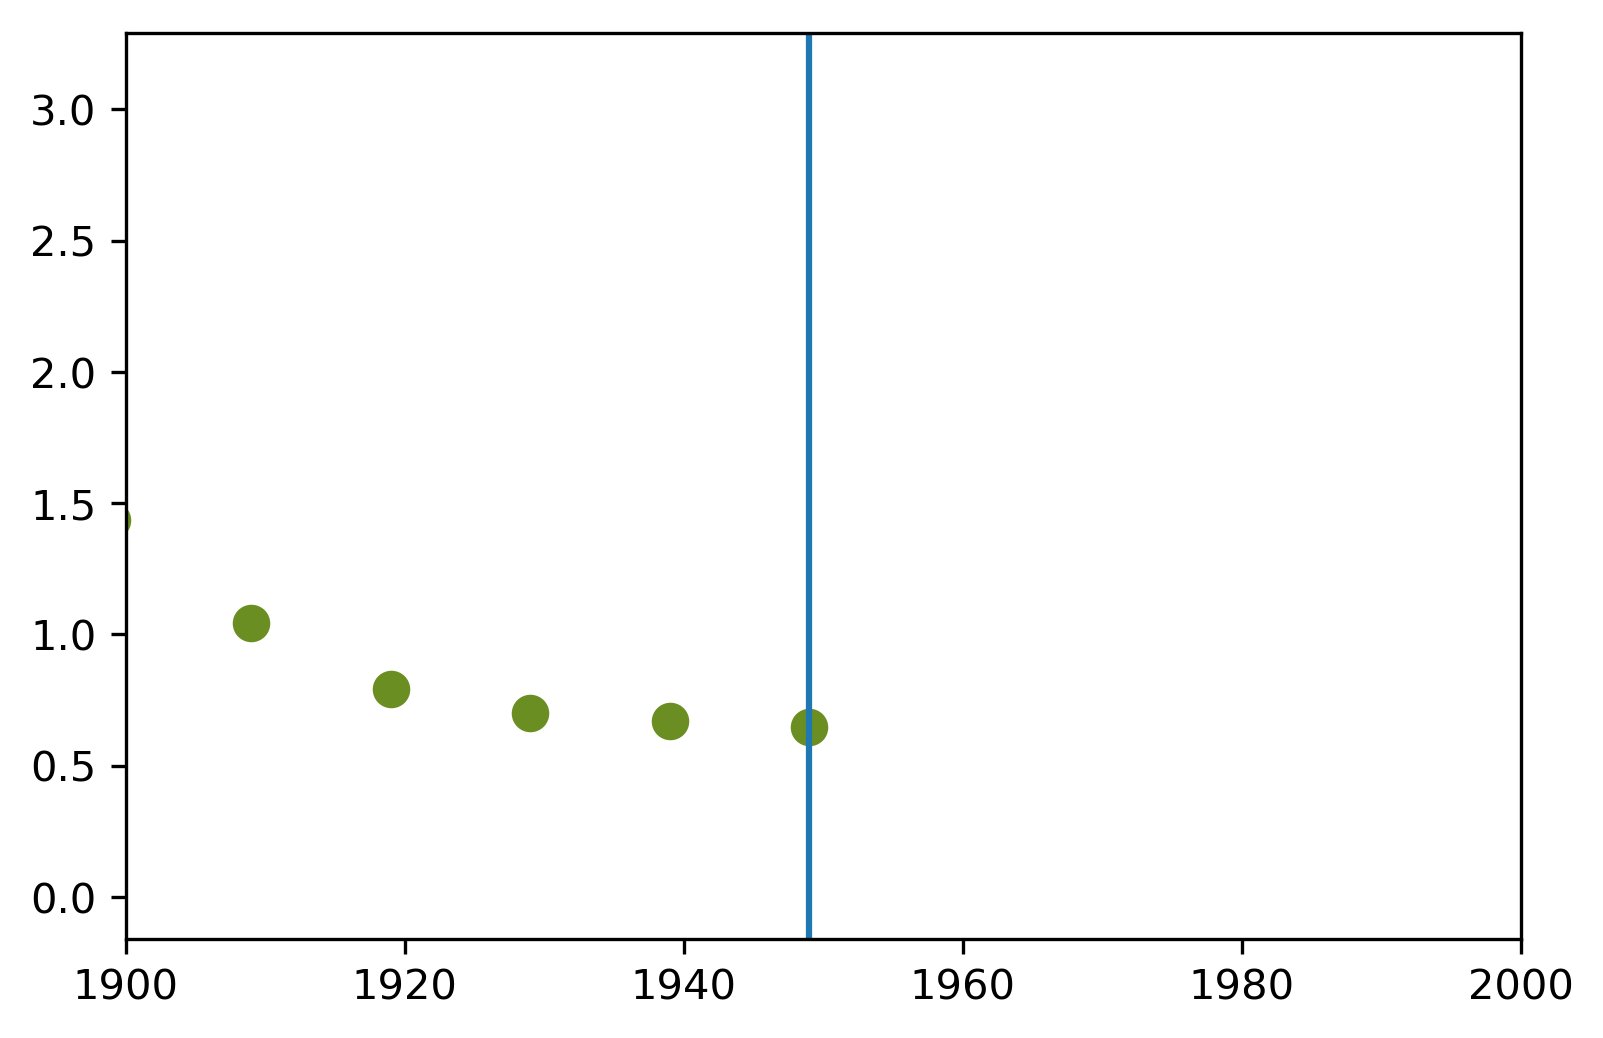

In [90]:
plt.scatter(kinnard_years, Masse_2008, color='olivedrab',linewidth=3, label='Masse et al. 2008')
plt.xlim(1900,2000)
plt.axvline(1949)

No handles with labels found to put in legend.


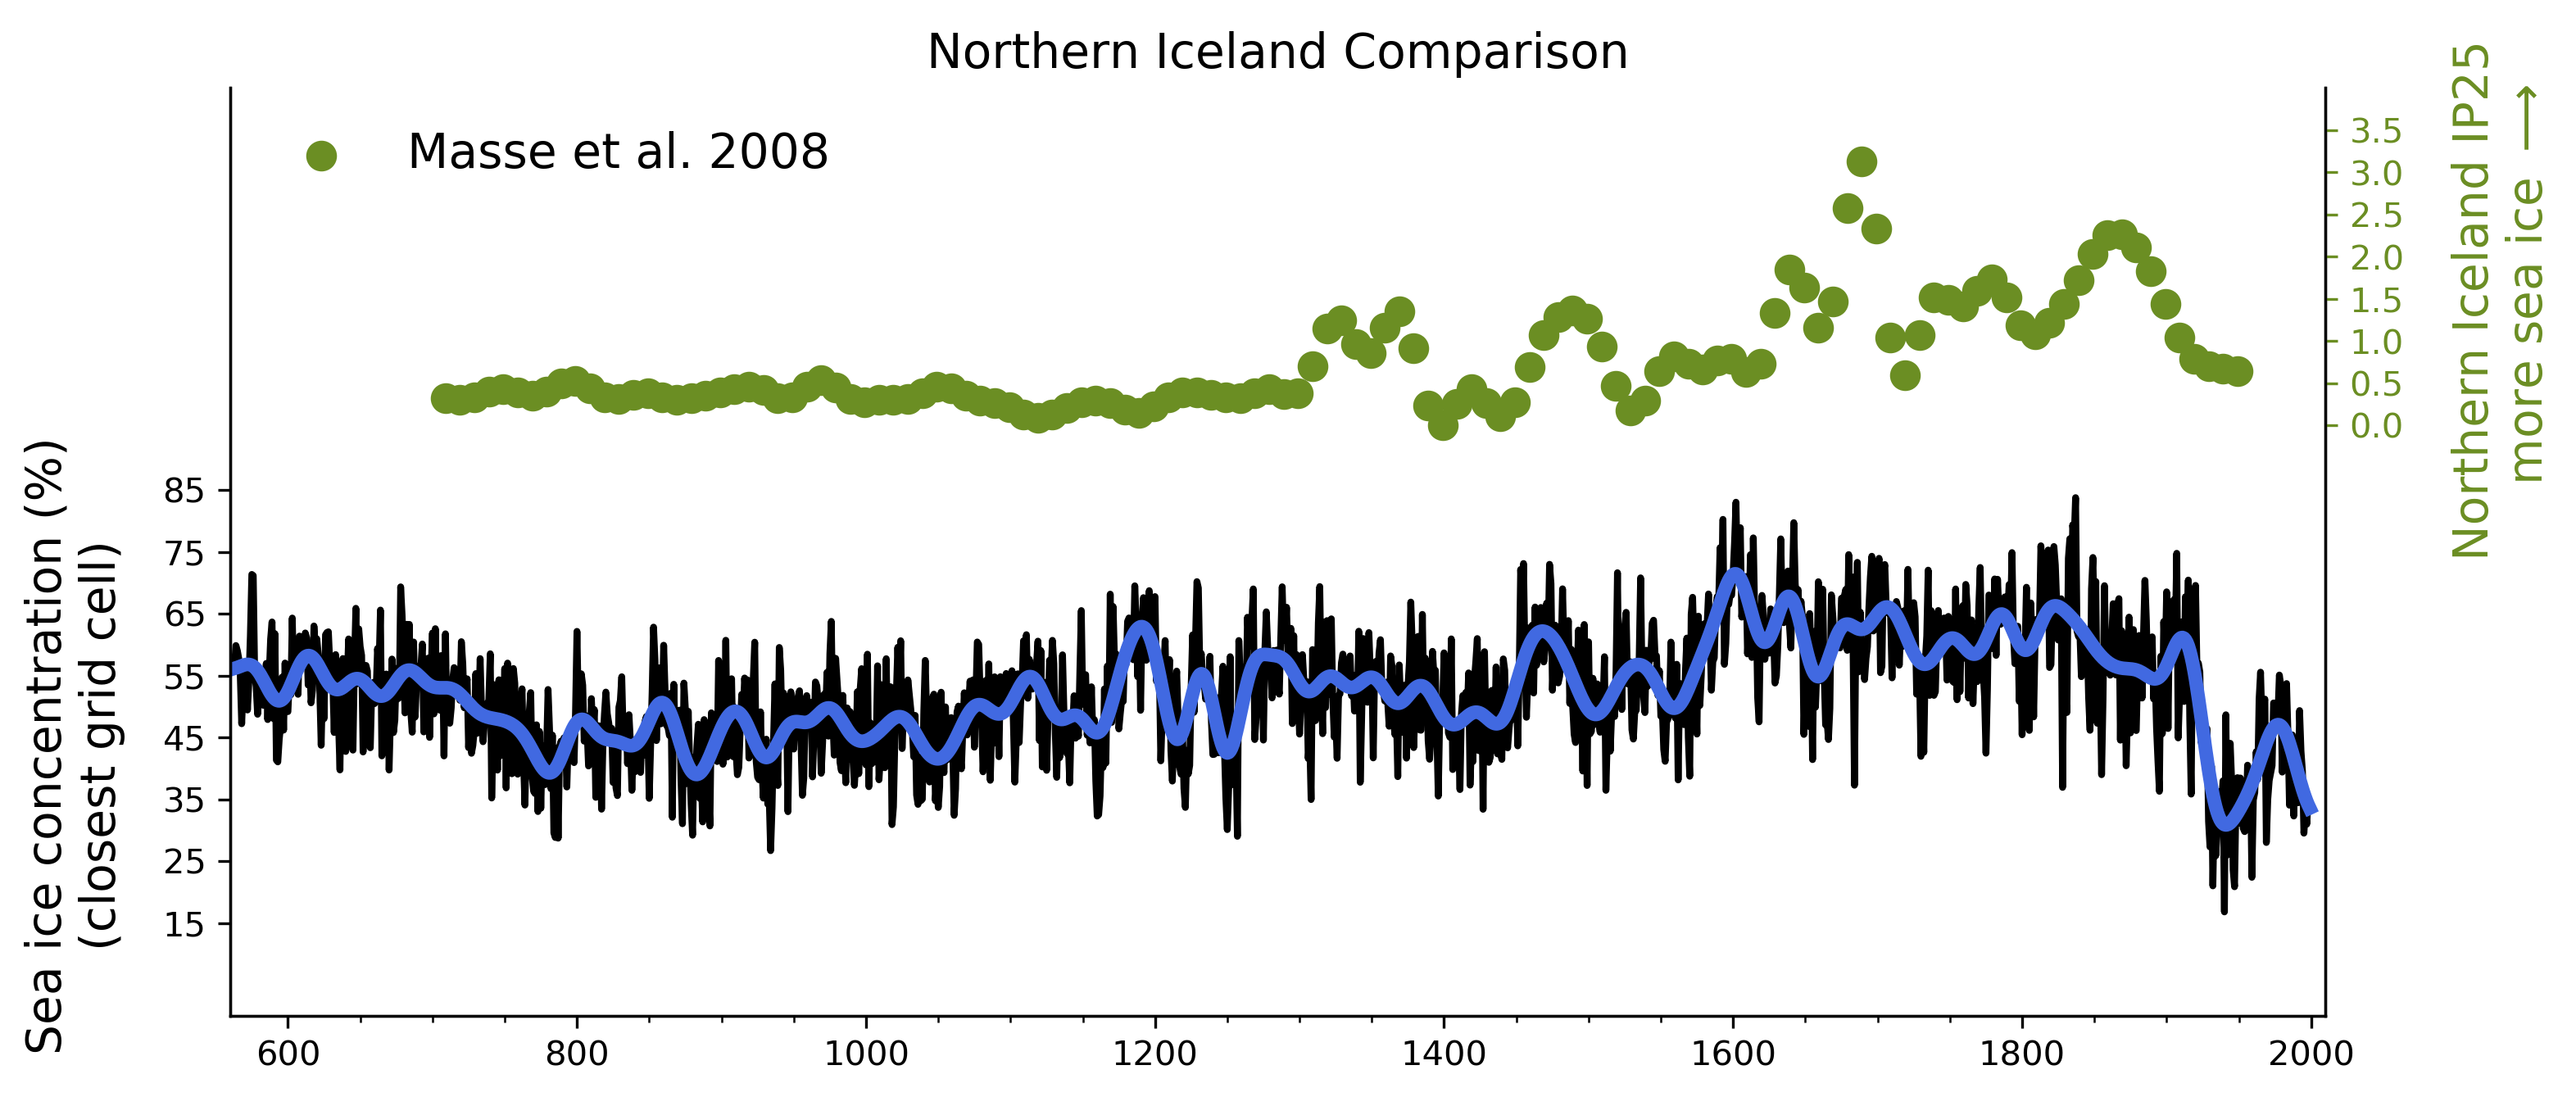

In [92]:
fig, ax_recon = plt.subplots(1, figsize=(11,5))

plt.plot(np.flip(kinnard_years[9:]), recon_Masse_enmn, color='k',linewidth=2)
plt.plot(np.flip(kinnard_years[9:]), ccsm4_Masse_filt20, color='royalblue',linewidth=4)
# plt.fill_between(np.flip(kinnard_years[9:]),recon_Masse_low,recon_Masse_high, color='gray', alpha=0.5)

ax_proxy = ax_recon.twinx()
plt.scatter(kinnard_years, Masse_2008, color='olivedrab',linewidth=3, label='Masse et al. 2008')

ax_proxy.set_ylim(-7,4)
ax_recon.set_ylim(0,150)
ax_proxy.set_xlim(560,2010)
ax_recon.set_xlim(560,2010)

ax_recon.spines['top'].set_visible(False)
ax_proxy.spines['top'].set_visible(False)

ax_recon.set_yticks(np.arange(15,86,10))
ax_proxy.set_yticks(np.arange(0,3.6,0.5))

ax_proxy.set_ylabel('Northern Iceland IP25 \n more sea ice $\longrightarrow$', fontsize=14)
ax_recon.set_ylabel('Sea ice concentration (%) \n(closest grid cell) ', fontsize=14)
plt.title('Northern Iceland Comparison', fontsize=14)

ax_proxy.yaxis.set_label_coords(1.06, 0.78)
ax_recon.yaxis.set_label_coords(-0.05, 0.3)

ax_proxy.yaxis.label.set_color('olivedrab')
ax_proxy.tick_params(axis='y', colors='olivedrab')

ax_proxy.legend(loc='upper left',frameon=False, fontsize=14)
ax_recon.legend(bbox_to_anchor=[0.325,0.94],frameon=False, fontsize=14)

#ax_recon.yaxis.set_minor_locator(MultipleLocator(2.5))
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))

In [96]:
[ce_fram_walsh_ccsm4,
 corr_fram_walsh_ccsm4,_,_] = rrutils.find_ce_corr(walsh_regional_sia['East Greenland Sea'], 
                                                   regional_sic_anom['East Greenland Sea'],
                                                   np.array(recon_years),
                                                   walsh_time,1850,1999)

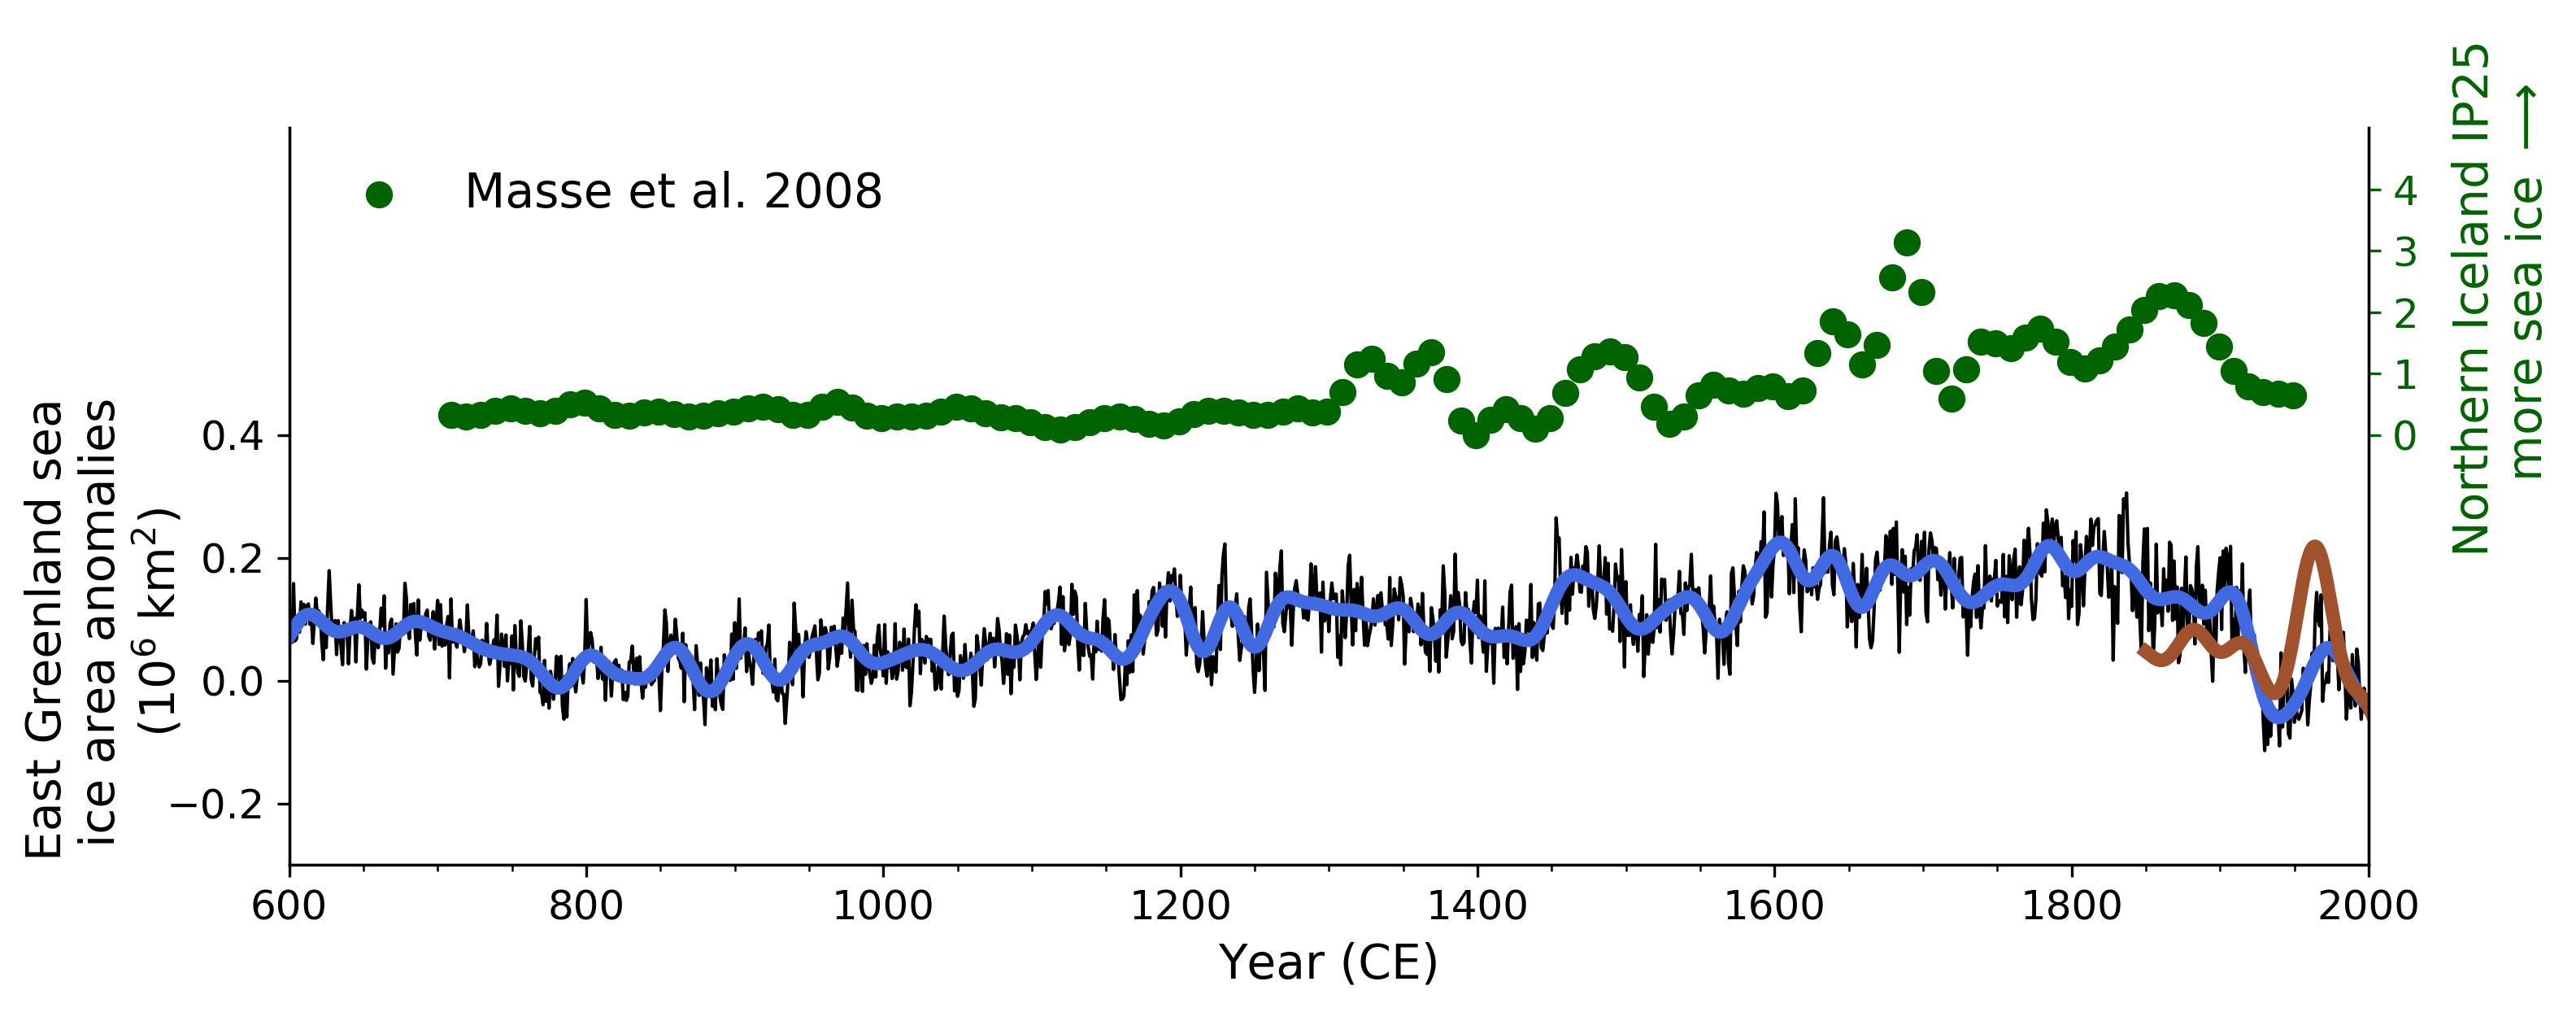

In [117]:
fig, ax_recon = plt.subplots(1, figsize=(11,4))

plt.plot(np.flip(kinnard_years[9:]), regional_sic_anom['East Greenland Sea'][min_yr:], color='k',linewidth=1,
        label='Reconstruction - CCSM4, Pages2k')
plt.plot(np.flip(kinnard_years[9:]), fram_sic_filt20[min_yr:], color='royalblue',linewidth=4,
         label='15 year filtered reconstruction')
# plt.fill_between(np.flip(kinnard_years[9:]),fram_sic_lowanom[min_yr:],
#                  fram_sic_highanom[min_yr:],color='gray',alpha=0.5, edgecolor=None)

plt.plot(walsh_time, fram_walsh_filt20, color='sienna',linewidth=4,
         label='Walsh et al. 2019')

ax_proxy = ax_recon.twinx()
plt.scatter(kinnard_years, Masse_2008, color='darkgreen',linewidth=2, label='Masse et al. 2008')

ax_proxy.set_ylim(-7,5)
ax_recon.set_ylim(-0.3,0.9)
ax_proxy.set_xlim(600,2000)
ax_recon.set_xlim(600,2000)

ax_recon.spines['top'].set_visible(False)
ax_proxy.spines['top'].set_visible(False)

ax_recon.set_yticks(np.arange(-0.2,0.4,0.2))
ax_proxy.set_yticks(np.arange(0,4.1,1))

ax_proxy.set_ylabel('Northern Iceland IP25 \n more sea ice $\longrightarrow$', fontsize=14)
ax_recon.set_ylabel('East Greenland sea \nice area anomalies\n(10$^6$ km$^2$)', fontsize=14)
ax_recon.set_xlabel('Year (CE)', fontsize=14)
#plt.title('Northern Iceland: Regional Comparison', fontsize=16)

ax_proxy.yaxis.set_label_coords(1.04, 0.78)
ax_recon.yaxis.set_label_coords(-0.05, 0.33)

ax_proxy.yaxis.label.set_color('darkgreen')
ax_proxy.tick_params(axis='y', colors='darkgreen')

#ax_proxy.legend(bbox_to_anchor=[0.305,1.05],frameon=False, fontsize=14)
ax_proxy.legend(loc = 'upper left',frameon=False, fontsize=14)
#ax_recon.legend(bbox_to_anchor=[0.49,0.965],frameon=False, fontsize=14)

#ax_recon.yaxis.set_minor_locator(MultipleLocator(2.5))
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))
# ax_recon.text(620,-0.25,('(Walsh, Reconstruction): R$^2$ = '+str(np.round(corr_fram_walsh_ccsm4**2,2))+
#                          ' CE = '+str(np.round(ce_fram_walsh_ccsm4,2))),fontsize=12)

ax_recon.tick_params(axis='both', which='major', labelsize=12)
ax_proxy.tick_params(axis='both', which='major', labelsize=12)

# ax_recon.axhline(0)
# ax_proxy.axhline(0)
# ax_recon.axvline(1300)